<h1>GET DATA</h1>
<p style="color:red">get data from Data sources and create a file for this data</p>


In [22]:
%pip install ta vaderSentiment
import yfinance as yf
import pandas as pd
import numpy as np
from ta import add_all_ta_features  # اگر فقط RSI نیاز دارید، می‌توانید ta را حذف کنید و فقط RSI محاسبه کنید
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from datetime import datetime, timedelta

# === تنظیمات اولیه ===
tickers = [
    "NVDA", "MSFT", "AAPL", "GOOGL", "GOOG", "AMZN", "META", "TSLA", "AVGO", "ASML",
    "NFLX", "AMD", "COST", "PEP", "LIN", "TMUS", "QCOM", "TXN", "AMAT", "INTU",
    "ADP", "REGN", "KLAC", "VRTX", "ISRG", "PANW", "SNPS", "CDNS", "MELI", "PYPL",
    "CTAS", "CSGP", "MRNA", "MAR", "CSX", "EA", "FAST", "CPRT", "EXC", "ROP",
    "PCAR", "VRSK", "DDOG", "FANG", "GILD", "GEHC", "IDXX", "ZS", "ODFL", "TTD",
    "MNST", "WDAY", "ABNB", "FTNT", "DASH", "DLTR", "PAYX", "AEP", "KDP", "CTSH",
    "BKNG", "ON", "CRWD", "MRVL", "NXPI", "LRCX", "MU", "ADI", "HON", "SBUX",
    "PDD", "CMG", "ORLY", "NXST", "VST", "TSCO", "ROST", "A", "TTWO", "BKR",
    "FICO", "YUM", "DLR", "HWM", "CCEP", "MSTR", "WELL", "XEL", "CLPBY",
    "EOG", "PSA", "URI"
]  # لیست تیکرها

api_key = "fd21bf6f585f45beae7bafe36d1b04fe"  # کلید NewsAPI خودتون

# === ۱. دانلود داده‌های اصلی (historical data با Dividends و Stock Splits) ===
print("📥 Downloading historical data...")
all_data = pd.DataFrame()
batch_size = 50  # برای جلوگیری از محدودیت yfinance
for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i + batch_size]
    try:
        data_batch = yf.download(
            batch,
            start="2020-01-01",
            end="2025-10-05",
            group_by="ticker",
            auto_adjust=False,
            actions=True
        )
        all_data = pd.concat([all_data, data_batch])
        print(f"Downloaded batch {i//batch_size + 1}")
    except Exception as e:
        print(f"Error in batch {i//batch_size + 1}: {e}")

# تبدیل به فرمت مناسب
historical_data = all_data.stack(level=0, future_stack=True).reset_index().rename(columns={"level_1": "Ticker"})
historical_data["Date"] = pd.to_datetime(historical_data["Date"])
historical_data = historical_data.dropna(subset=["Open", "High", "Low", "Close"])
historical_data = historical_data.drop_duplicates(subset=["Date", "Ticker"])
historical_data = historical_data.sort_values(by=["Ticker", "Date"])

# === ۲. اضافه کردن نام شرکت و fundamentals ===
print("📊 Adding company info and fundamentals...")
company_info = []
for ticker in tickers:
    try:
        t = yf.Ticker(ticker)
        info = t.info
        company_name = info.get('longName', info.get('shortName', 'N/A'))
        company_info.append({
            "Ticker": ticker,
            "Company": company_name,
            "Market Cap": info.get("marketCap", None),
            "P/E Ratio": info.get("trailingPE", None),
            "EPS": info.get("trailingEps", None),
            "Sector": info.get("sector", "N/A"),
            "Industry": info.get("industry", "N/A")
        })
    except Exception as e:
        print(f"Error for {ticker}: {e}")
        company_info.append({
            "Ticker": ticker,
            "Company": "N/A",
            "Market Cap": None,
            "P/E Ratio": None,
            "EPS": None,
            "Sector": "N/A",
            "Industry": "N/A"
        })

company_df = pd.DataFrame(company_info)
enhanced_data = historical_data.merge(company_df, on="Ticker", how="left")

# === ۳. اضافه کردن technical indicators (با ta - اگر همه ویژگی‌ها لازم نیست، می‌توانید فقط RSI اضافه کنید) ===
print("📈 Adding technical indicators...")
enhanced_data = add_all_ta_features(enhanced_data, open="Open", high="High", low="Low", close="Close", volume="Volume")

# اگر فقط RSI نیاز دارید، این خط را جایگزین کنید (برای بهینه‌سازی):
# def calculate_rsi(series, period=14):
#     delta = series.diff()
#     gain = np.where(delta > 0, delta, 0)
#     loss = np.where(delta < 0, -delta, 0)
#     avg_gain = pd.Series(gain).rolling(window=period).mean()
#     avg_loss = pd.Series(loss).rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return rsi
# enhanced_data["momentum_rsi"] = enhanced_data.groupby("Ticker")["Adj Close"].transform(calculate_rsi)

# === ۴. جمع‌آوری اخبار و تحلیل sentiment (فقط ۳۰ روز اخیر برای بهینه‌سازی) ===
print("📡 Collecting news and analyzing sentiment...")
end_date = datetime.today()
start_date = end_date - timedelta(days=30)
start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")

news_data = []
analyzer = SentimentIntensityAnalyzer()
for ticker in tickers:
    try:
        url = f"https://newsapi.org/v2/everything?q={ticker} stock&from={start_str}&to={end_str}&sortBy=relevancy&language=en&apiKey={api_key}"
        response = requests.get(url)
        data_json = response.json()
        articles = data_json.get("articles", [])

        for article in articles[:20]:  # محدود به ۲۰ خبر برای هر تیکر (برای جلوگیری از محدودیت API)
            text = (article.get("title", "") or "") + " " + (article.get("description", "") or "")
            sentiment_score = analyzer.polarity_scores(text)["compound"]
            news_data.append({
                "Date": pd.to_datetime(article["publishedAt"].split("T")[0]),
                "Ticker": ticker,
                "Sentiment": sentiment_score
            })
    except Exception as e:
        print(f"⚠️ Error for {ticker}: {e}")

if news_data:
    news_df = pd.DataFrame(news_data)
    sentiment_daily = news_df.groupby(["Date", "Ticker"])["Sentiment"].mean().reset_index()
    enhanced_data = enhanced_data.merge(sentiment_daily, on=["Date", "Ticker"], how="left")
    enhanced_data["Sentiment"] = enhanced_data["Sentiment"].fillna(0)
else:
    enhanced_data["Sentiment"] = 0

# === ۵. تمیز کردن نهایی و ذخیره فقط یک فایل ===
enhanced_data = enhanced_data.sort_values(by=["Ticker", "Date"])
enhanced_data.to_csv("final_enhanced_stock_dataset.csv", index=False)
print("\n💾 Final dataset saved to final_enhanced_stock_dataset.csv")
print(f"Columns: {enhanced_data.columns.tolist()}")
print("\n📊 Sample:")
print(enhanced_data.head(5))

📥 Downloading historical data...


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

Downloaded batch 1


[*********************100%***********************]  42 of 42 completed


Downloaded batch 2
📊 Adding company info and fundamentals...
📈 Adding technical indicators...
📡 Collecting news and analyzing sentiment...

💾 Final dataset saved to final_enhanced_stock_dataset.csv
Columns: ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'Company', 'Market Cap', 'P/E Ratio', 'EPS', 'Sector', 'Industry', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

df = pd.read_csv("final_enhanced_stock_dataset.csv")
print(f"INFO : \n\n {df.info} \n\n\n\n DESCRIBE : \n\n {df.describe}")

INFO : 

 <bound method DataFrame.info of               Date Ticker        Open        High         Low       Close  \
0       2020-01-02      A   85.900002   86.349998   85.199997   85.949997   
1       2020-01-03      A   84.669998   85.330002   84.500000   84.570000   
2       2020-01-06      A   84.000000   84.820000   83.599998   84.820000   
3       2020-01-07      A   83.959999   85.260002   83.940002   85.080002   
4       2020-01-08      A   85.959999   86.470001   85.199997   85.919998   
...            ...    ...         ...         ...         ...         ...   
131899  2025-09-29     ZS  297.109985  300.809998  293.510010  296.899994   
131900  2025-09-30     ZS  295.839996  300.209991  291.570007  299.660004   
131901  2025-10-01     ZS  298.609985  305.910004  297.135010  304.529999   
131902  2025-10-02     ZS  306.000000  307.790009  302.149994  307.579987   
131903  2025-10-03     ZS  308.070007  309.790009  301.709991  305.410004   

         Adj Close     Volume  Di

<h1>DATA ANALYSIS</h1>
<p>Data cleaning</p>

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# 1. بارگذاری داده‌ها
df = pd.read_csv('final_enhanced_stock_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])  # تبدیل ستون تاریخ به فرمت datetime

# 2. پر کردن داده‌های گمشده
df['Sentiment'] = df['Sentiment'].fillna(0)  # پر کردن مقادیر گمشده Sentiment با 0
numeric_cols = df.select_dtypes(include=[np.number]).columns  # انتخاب ستون‌های عددی
df[numeric_cols] = df.groupby('Ticker')[numeric_cols].ffill()  # پر کردن مقادیر گمشده با مقدار قبلی هر تیکر
df = df.dropna(thresh=len(df.columns) - 10)  # حذف ردیف‌هایی که بیش از 10 مقدار گمشده دارند

# 3. ایجاد متغیر هدف (بازده 7 روزه) با بهینه‌سازی
return_7d = df.groupby('Ticker')['Adj Close'].shift(-7) / df['Adj Close'] - 1  # محاسبه بازده 7 روزه
df = pd.concat([df, return_7d.rename('Return_7d')], axis=1)  # افزودن ستون با concat برای جلوگیری از هشدار

# 4. تعریف ویژگی‌ها
features = df.select_dtypes(include=[np.number]).columns.drop('Return_7d', errors='ignore').tolist()  # انتخاب ویژگی‌های عددی

# 5. نرمال‌سازی ویژگی‌ها برای هر تیکر
for ticker in df['Ticker'].unique():  # حلقه روی هر تیکر
    mask = df['Ticker'] == ticker  # فیلتر داده‌های تیکر
    ticker_df = df.loc[mask, features].fillna(0)  # پر کردن NaN با 0 برای نرمال‌سازی
    scaler = StandardScaler()  # ایجاد نمونه اسکیلر
    scaled = scaler.fit_transform(ticker_df)  # نرمال‌سازی داده‌ها
    df.loc[mask, features] = scaled  # جایگزینی داده‌های نرمال‌شده

# 6. حذف ردیف‌های بدون هدف یا ویژگی
df = df.dropna(subset=features + ['Return_7d'])  # حذف ردیف‌های بدون ویژگی یا هدف

# 7. تقسیم داده‌ها به train/test با TimeSeriesSplit
X = df[features]  # ویژگی‌ها
y = df['Return_7d']  # هدف
tscv = TimeSeriesSplit(n_splits=5)  # تقسیم زمانی به 5 بخش
for train_idx, test_idx in tscv.split(X):  # حلقه روی تقسیم‌ها
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]  # داده‌های آموزشی و آزمایشی ویژگی‌ها
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]  # داده‌های آموزشی و آزمایشی هدف
    # این داده‌ها برای آموزش مدل استفاده می‌شوند

# 8. ذخیره داده‌های پیش‌پردازش‌شده
df.to_csv('preprocessed_stock_data.csv', index=False)  # ذخیره داده‌ها
print("داده‌ها پیش‌پردازش و ذخیره شدند.")
print(df.head())  # نمایش 5 ردیف اول
print(df.isnull().sum())  # نمایش تعداد مقادیر گمشده

داده‌ها پیش‌پردازش و ذخیره شدند.
         Date Ticker      Open      High       Low     Close  Adj Close  \
33 2020-02-20      A -2.056830 -2.118964 -2.069832 -2.088786  -2.146312   
34 2020-02-21      A -2.105174 -2.114137 -2.067887 -2.053404  -2.112008   
35 2020-02-24      A -2.186390 -2.234815 -2.232183 -2.274907  -2.326769   
36 2020-02-25      A -2.259873 -2.317358 -2.345439 -2.398502  -2.446602   
37 2020-02-26      A -2.358493 -2.346803 -2.325996 -2.390747  -2.439084   

      Volume  Dividends  Stock Splits  ... momentum_ppo_hist  momentum_pvo  \
33  0.936937  -0.127872           0.0  ...          0.214335      1.819072   
34 -0.009164  -0.127872           0.0  ...          0.224670      1.413052   
35  1.391879  -0.127872           0.0  ...         -0.347634      1.568075   
36  1.208740  -0.127872           0.0  ...         -1.008051      1.599926   
37  0.915619  -0.127872           0.0  ...         -1.344897      1.506648   

    momentum_pvo_signal  momentum_pvo_hist mome

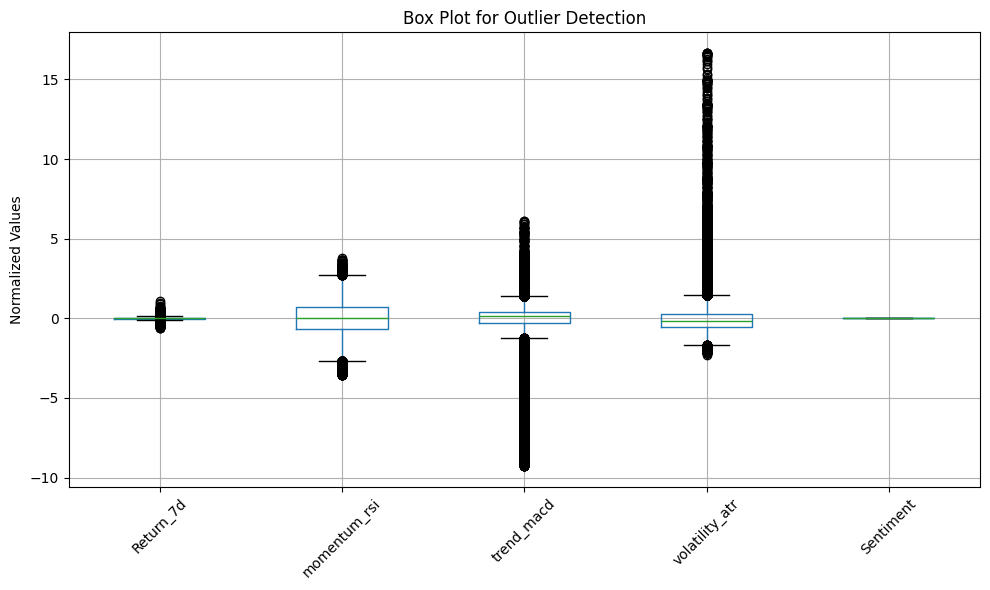

تعداد نقاط پرت در Return_7d: 7163
تعداد نقاط پرت در momentum_rsi: 1588
تعداد نقاط پرت در trend_macd: 13112
تعداد نقاط پرت در volatility_atr: 8335
تعداد نقاط پرت در Sentiment: 0


In [25]:
import matplotlib.pyplot as plt

# بارگذاری داده‌های پیش‌پردازش‌شده
df = pd.read_csv('preprocessed_stock_data.csv')

# انتخاب ویژگی‌های کلیدی برای بررسی
key_features = ['Return_7d', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Sentiment']

# رسم نمودار جعبه‌ای
plt.figure(figsize=(10, 6))
df[key_features].boxplot()
plt.title('Box Plot for Outlier Detection')
plt.xticks(rotation=45)
plt.ylabel('Normalized Values')
plt.tight_layout()
plt.show()

# محاسبه تعداد نقاط پرت با روش IQR
outliers = {}
for feature in key_features:
    Q1 = df[feature].quantile(0.25)  # چارک اول
    Q3 = df[feature].quantile(0.75)  # چارک سوم
    IQR = Q3 - Q1  # محدوده بین‌چارکی
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = len(df[(df[feature] < lower_bound) | (df[feature] > upper_bound)])
    outliers[feature] = outlier_count
    print(f"تعداد نقاط پرت در {feature}: {outlier_count}")

In [26]:

# بارگذاری داده‌ها
df = pd.read_csv('preprocessed_stock_data.csv')

# انتخاب ویژگی‌های کلیدی
key_features = ['Return_7d', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Sentiment']

# محدود کردن نقاط پرت با روش IQR
for feature in key_features:
    Q1 = df[feature].quantile(0.25)  # چارک اول
    Q3 = df[feature].quantile(0.75)  # چارک سوم
    IQR = Q3 - Q1  # محدوده بین‌چارکی
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = df[feature].clip(lower_bound, upper_bound)  # محدود کردن مقادیر به بازه مجاز

# ذخیره داده‌های اصلاح‌شده
df.to_csv('preprocessed_stock_data_no_outliers.csv', index=False)
print("داده‌ها با حذف نقاط پرت ذخیره شدند.")
print(df.head())
print(df.isnull().sum())

داده‌ها با حذف نقاط پرت ذخیره شدند.
         Date Ticker      Open      High       Low     Close  Adj Close  \
0  2020-02-20      A -2.056830 -2.118964 -2.069832 -2.088786  -2.146312   
1  2020-02-21      A -2.105174 -2.114137 -2.067887 -2.053404  -2.112008   
2  2020-02-24      A -2.186390 -2.234815 -2.232183 -2.274907  -2.326769   
3  2020-02-25      A -2.259873 -2.317358 -2.345439 -2.398502  -2.446602   
4  2020-02-26      A -2.358493 -2.346803 -2.325996 -2.390747  -2.439084   

     Volume  Dividends  Stock Splits  ... momentum_ppo_hist  momentum_pvo  \
0  0.936937  -0.127872           0.0  ...          0.214335      1.819072   
1 -0.009164  -0.127872           0.0  ...          0.224670      1.413052   
2  1.391879  -0.127872           0.0  ...         -0.347634      1.568075   
3  1.208740  -0.127872           0.0  ...         -1.008051      1.599926   
4  0.915619  -0.127872           0.0  ...         -1.344897      1.506648   

   momentum_pvo_signal  momentum_pvo_hist momentum

آماره‌های توصیفی برای ویژگی‌های کلیدی:
           Return_7d   momentum_rsi     trend_macd  volatility_atr  Sentiment
count  131227.000000  131227.000000  131227.000000   131227.000000   131227.0
mean        0.006335       0.002500       0.061289       -0.075035        0.0
std         0.055252       0.988788       0.647626        0.695793        0.0
min        -0.122979      -2.676981      -1.268324       -1.703176        0.0
25%        -0.026143      -0.652860      -0.268592       -0.519192        0.0
50%         0.006215       0.025900       0.137939       -0.158967        0.0
75%         0.038414       0.696553       0.397895        0.270131        0.0
max         0.135250       2.720674       1.397627        1.454115        0.0


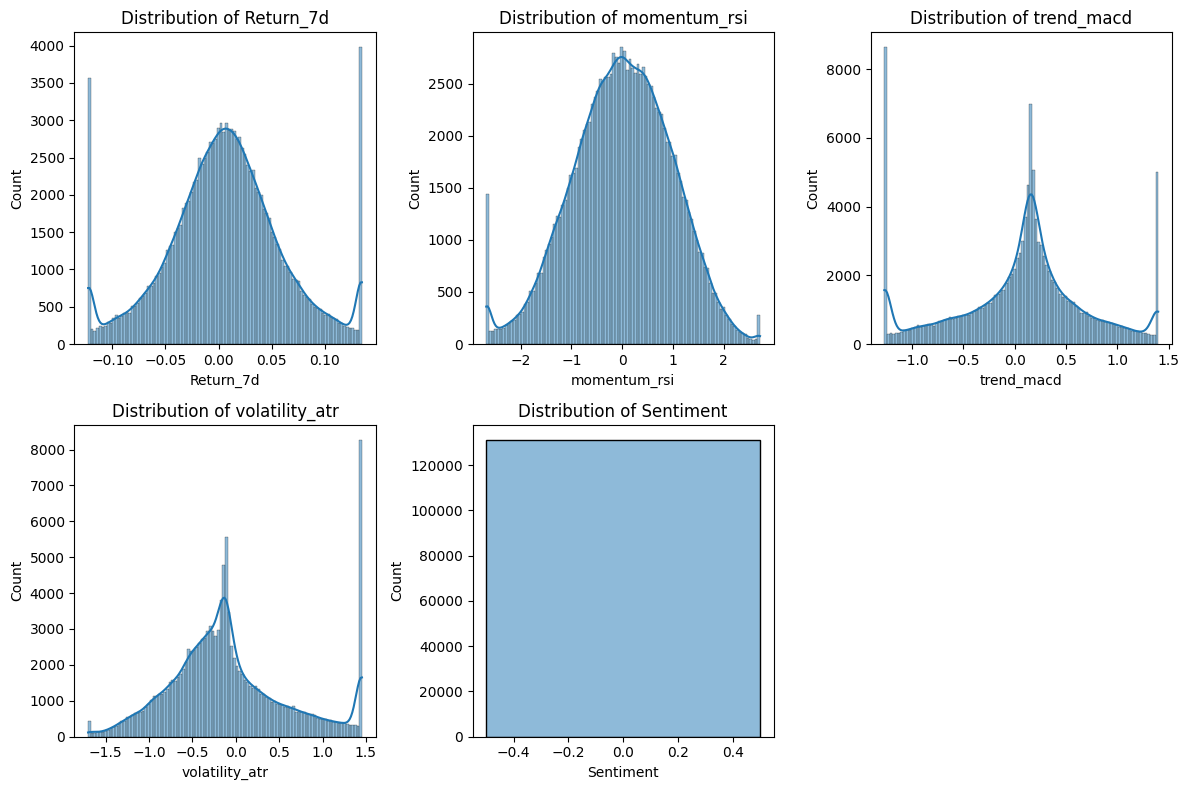

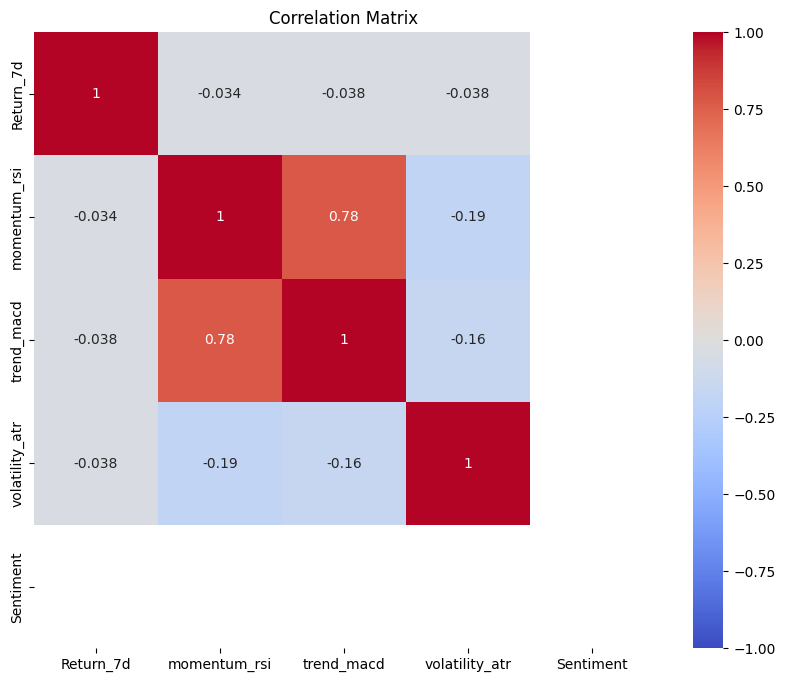

آزمون Shapiro-Wilk برای Return_7d: Statistic=0.986, p-value=0.000
   Return_7d توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای momentum_rsi: Statistic=0.996, p-value=0.000
   momentum_rsi توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای trend_macd: Statistic=0.962, p-value=0.000
   trend_macd توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای volatility_atr: Statistic=0.957, p-value=0.000
   volatility_atr توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای Sentiment: Statistic=1.000, p-value=1.000
   Sentiment توزیع نرمال دارد (p > 0.05)


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# بارگذاری داده‌ها
df = pd.read_csv('preprocessed_stock_data_no_outliers.csv')

# 1. بررسی آماره‌های توصیفی
print("آماره‌های توصیفی برای ویژگی‌های کلیدی:")
key_features = ['Return_7d', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Sentiment']
print(df[key_features].describe())

# 2. رسم هیستوگرام برای توزیع داده‌ها
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# 3. ماتریس همبستگی
plt.figure(figsize=(10, 8))
correlation_matrix = df[key_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# 4. آزمون نرمال بودن (Shapiro-Wilk)
for feature in key_features:
    stat, p_value = shapiro(df[feature])
    print(f"آزمون Shapiro-Wilk برای {feature}: Statistic={stat:.3f}, p-value={p_value:.3f}")
    if p_value > 0.05:
        print(f"   {feature} توزیع نرمال دارد (p > 0.05)")
    else:
        print(f"   {feature} توزیع نرمال ندارد (p <= 0.05)")

داده‌ها با تبدیل ذخیره شدند.
آماره‌های توصیفی برای ویژگی‌های کلیدی:
          Return_7d  momentum_rsi    trend_macd  volatility_atr  Sentiment
count  1.312270e+05  1.312270e+05  1.312270e+05    1.312270e+05   131227.0
mean  -1.949259e-17  3.194619e-18 -3.032180e-18   -3.465349e-18        0.0
std    1.000004e+00  1.000004e+00  1.000004e+00    1.000004e+00        0.0
min   -2.354770e+00 -2.546473e+00 -1.927036e+00   -2.962831e+00        0.0
25%   -5.857613e-01 -6.813874e-01 -5.461074e-01   -5.989136e-01        0.0
50%    1.013170e-03 -1.119044e-02  7.193791e-02   -9.479213e-03        0.0
75%    5.827086e-01  6.890425e-01  4.902875e-01    5.951571e-01        0.0
max    2.319415e+00  2.949921e+00  2.226996e+00    1.903494e+00        0.0


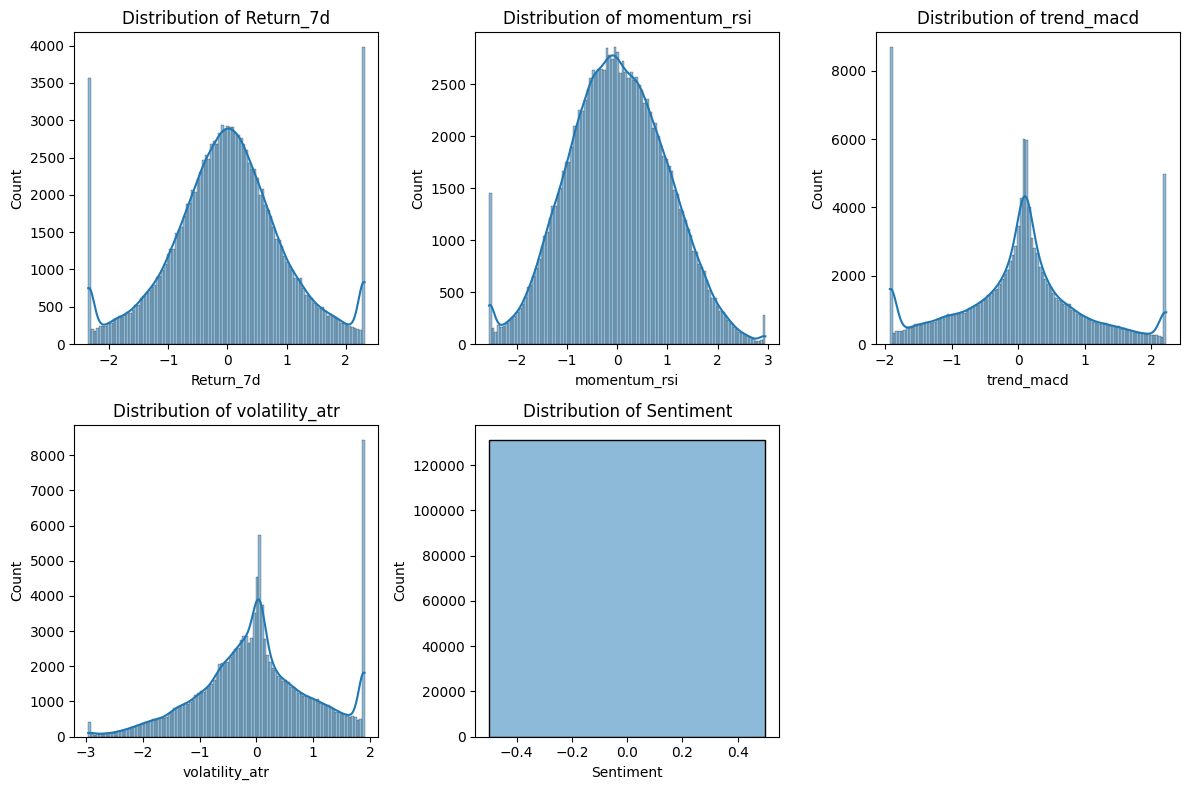

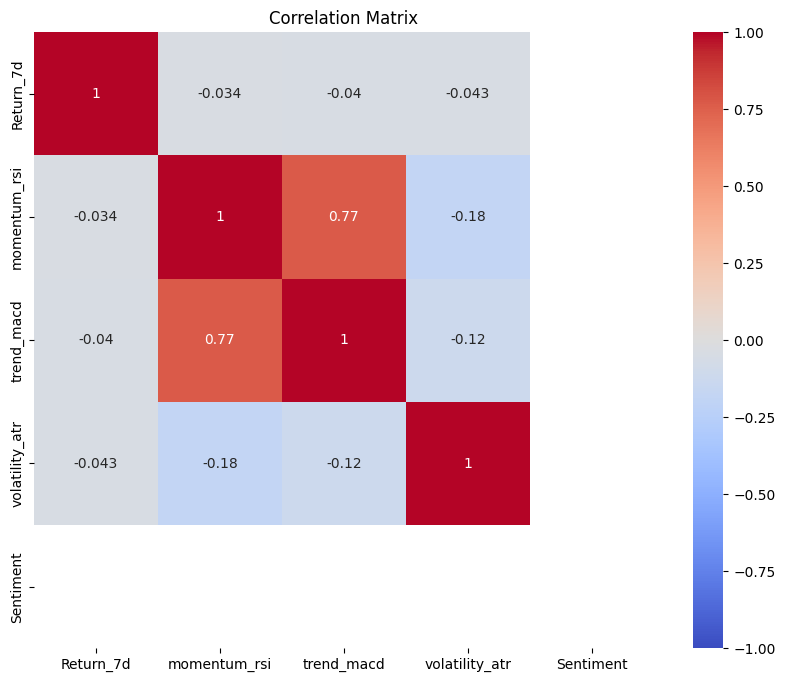

آزمون Shapiro-Wilk برای Return_7d: Statistic=0.986, p-value=0.000
   Return_7d توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای momentum_rsi: Statistic=0.998, p-value=0.000
   momentum_rsi توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای trend_macd: Statistic=0.966, p-value=0.000
   trend_macd توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای volatility_atr: Statistic=0.982, p-value=0.000
   volatility_atr توزیع نرمال ندارد (p <= 0.05)
آزمون Shapiro-Wilk برای Sentiment: Statistic=1.000, p-value=1.000
   Sentiment توزیع نرمال دارد (p > 0.05)


In [29]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# بارگذاری داده‌ها
df = pd.read_csv('preprocessed_stock_data_no_outliers.csv')

# تبدیل داده‌ها با PowerTransformer
features_to_transform = ['Return_7d', 'momentum_rsi', 'trend_macd', 'volatility_atr']
pt = PowerTransformer(method='yeo-johnson')
df[features_to_transform] = pt.fit_transform(df[features_to_transform])

# ذخیره داده‌های تبدیل‌شده
df.to_csv('preprocessed_stock_data_transformed.csv', index=False)
print("داده‌ها با تبدیل ذخیره شدند.")

# 1. بررسی آماره‌های توصیفی
print("آماره‌های توصیفی برای ویژگی‌های کلیدی:")
key_features = ['Return_7d', 'momentum_rsi', 'trend_macd', 'volatility_atr', 'Sentiment']
print(df[key_features].describe())

# 2. رسم هیستوگرام برای توزیع داده‌ها
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# 3. ماتریس همبستگی
plt.figure(figsize=(10, 8))
correlation_matrix = df[key_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# 4. آزمون نرمال بودن (Shapiro-Wilk)
for feature in key_features:
    stat, p_value = shapiro(df[feature])
    print(f"آزمون Shapiro-Wilk برای {feature}: Statistic={stat:.3f}, p-value={p_value:.3f}")
    if p_value > 0.05:
        print(f"   {feature} توزیع نرمال دارد (p > 0.05)")
    else:
        print(f"   {feature} توزیع نرمال ندارد (p <= 0.05)")

<h1>FEATURE ENGINEERING</h1>



اطلاعات کلی:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131227 entries, 0 to 131226
Columns: 104 entries, Date to Return_7d
dtypes: datetime64[ns](1), float64(97), int64(2), object(4)
memory usage: 104.1+ MB

آماره‌های توصیفی:
                                Date           Open           High  \
count                         131227  131227.000000  131227.000000   
mean   2022-11-17 12:00:58.268496384      -0.006404      -0.006422   
min              2020-01-02 00:00:00      -4.121673      -3.980497   
25%              2021-06-16 00:00:00      -0.698708      -0.698818   
50%              2022-11-17 00:00:00      -0.094986      -0.097893   
75%              2024-04-23 00:00:00       0.680759       0.679655   
max              2025-09-24 00:00:00       4.292697       4.242501   
std                              NaN       0.994368       0.994293   

                 Low          Close      Adj Close         Volume  \
count  131227.000000  131227.000000  131227.000000  131227.000000 

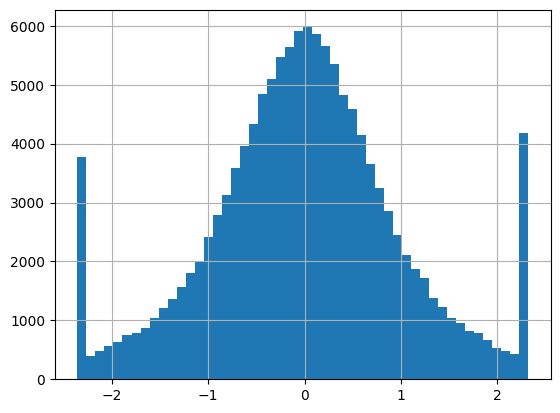

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. بارگذاری داده‌ها
df = pd.read_csv('preprocessed_stock_data_transformed.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# حفظ کپی از Ticker
ticker_column = df['Ticker'].copy()

# 2. بررسی داده‌ها
print("اطلاعات کلی:")
df.info()
print("\nآماره‌های توصیفی:")
print(df.describe())
print("\nتعداد NaN در هر ستون:")
print(df.isnull().sum())
print("\nتعداد ردیف‌ها برای هر تیکر:")
print(df['Ticker'].value_counts())
print("\nبررسی توزیع Return_7d:")
df['Return_7d'].hist(bins=50)

# 3. حذف ویژگی‌های کم‌اهمیت
df = df.drop(columns=['Sentiment', 'Company', 'Sector', 'Industry'])

# 4. مهندسی ویژگی پیشرفته
# 4.1. لگ‌ها و تغییرات
for lag in [1, 3, 5]:
    df[f'Adj_Close_Lag_{lag}'] = df.groupby('Ticker')['Adj Close'].shift(lag)
    df[f'Return_Lag_{lag}'] = df.groupby('Ticker')['Return_7d'].shift(lag)

# 4.2. میانگین‌های متحرک و کراس‌اوورها
windows = [5, 10, 20]
for window in windows:
    df[f'SMA_{window}'] = df.groupby('Ticker')['Adj Close'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
    df[f'EMA_{window}'] = df.groupby('Ticker')['Adj Close'].ewm(span=window, adjust=False, min_periods=1).mean().reset_index(0, drop=True)
df['SMA_Crossover'] = np.where(df['SMA_5'] > df['SMA_20'], 1, 0)

# 4.3. نسبت‌های مالی پیشرفته
df['EPS'] = df['EPS'].replace(0, np.nan).fillna(df.groupby('Ticker')['EPS'].transform('mean'))
df['Market Cap'] = df['Market Cap'].replace(0, np.nan).fillna(df.groupby('Ticker')['Market Cap'].transform('mean'))
df['PE_to_EPS'] = df['P/E Ratio'] / df['EPS']
df['Volume_to_MarketCap'] = df['Volume'] / df['Market Cap']
df['RSI_MACD_Ratio'] = df['momentum_rsi'] / (df['trend_macd'].replace(0, 1e-6) + 1e-6)

# 4.4. ویژگی‌های نوسانات
df['Volatility_Rolling_Std'] = df.groupby('Ticker')['Adj Close'].rolling(window=10, min_periods=1).std().reset_index(0, drop=True)
df['Sharpe_Ratio'] = df['Return_7d'] / (df['Volatility_Rolling_Std'] + 1e-6)

# 4.5. ویژگی‌های مبتنی بر همبستگی با بازار
df['Market_Return'] = df.groupby('Date')['Adj Close'].transform('mean')
# محاسبه Beta با روش جایگزین
beta_values = []
for ticker in df['Ticker'].unique():
    mask = df['Ticker'] == ticker
    adj_close = df.loc[mask, 'Adj Close']
    market_return = df.loc[mask, 'Market_Return']
    if len(adj_close) > 1 and len(market_return) > 1:
        beta = np.corrcoef(adj_close, market_return)[0, 1]
    else:
        beta = 0
    beta_values.extend([beta] * len(adj_close))
df['Beta'] = beta_values

# 4.6. کاهش ابعادی با PCA
tech_features = [col for col in df.columns if 'momentum_' in col or 'trend_' in col or 'volatility_' in col]
scaler = StandardScaler()
pca = PCA(n_components=5)
df_tech_scaled = pd.DataFrame(scaler.fit_transform(df[tech_features]), columns=tech_features, index=df.index)
pca_features = pca.fit_transform(df_tech_scaled)
for i in range(pca_features.shape[1]):
    df[f'PCA_Tech_{i+1}'] = pca_features[:, i]

# 4.7. ویژگی‌های زمانی
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# 5. مدیریت NaN با درون‌یابی
df = df.infer_objects(copy=False)
df = df.groupby('Ticker', group_keys=False).apply(
    lambda x: x.interpolate(method='linear', limit_direction='both').fillna(0),
    include_groups=False
).reset_index()  # بازگرداندن Ticker به ستون

# بازیابی ستون Ticker
df['Ticker'] = ticker_column

# 6. حذف مقادیر غیرمجاز
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

# 7. انتخاب ویژگی
features = df.select_dtypes(include=[np.number]).columns.drop('Return_7d')
if len(features) > 0 and len(df) > 0:
    X = df[features]
    y = df['Return_7d']
    selector = SelectKBest(mutual_info_regression, k=min(50, len(features)))
    X_selected = selector.fit_transform(X, y)
    selected_features = features[selector.get_support()].tolist()
else:
    print("خطا: داده‌ها برای انتخاب ویژگی کافی نیستند.")
    selected_features = []

# 8. ذخیره DataFrame نهایی
df_final = df[selected_features + ['Ticker', 'Date', 'Return_7d']]
df_final.to_csv('engineered_stock_data.csv', index=False)

print("مهندسی ویژگی انجام شد. ویژگی‌های انتخاب‌شده:", selected_features)
print(df_final.head())
print(df_final.shape)

<h1>EDA</h1>


General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131227 entries, 0 to 131226
Data columns (total 53 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    131227 non-null  int64  
 1   Adj Close                131227 non-null  float64
 2   Dividends                131227 non-null  float64
 3   EPS                      131227 non-null  float64
 4   volume_vpt               131227 non-null  float64
 5   volume_vwap              131227 non-null  float64
 6   volume_nvi               131227 non-null  float64
 7   volatility_bbm           131227 non-null  float64
 8   volatility_bbh           131227 non-null  float64
 9   volatility_bbl           131227 non-null  float64
 10  volatility_bbhi          131227 non-null  float64
 11  volatility_bbli          131227 non-null  float64
 12  volatility_kcc           131227 non-null  float64
 13  volatility_kcl           131227 non-nu

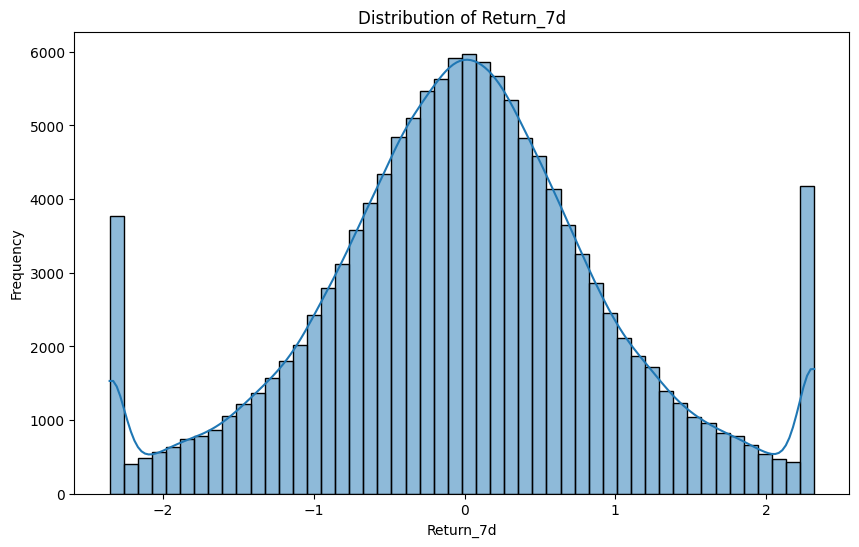

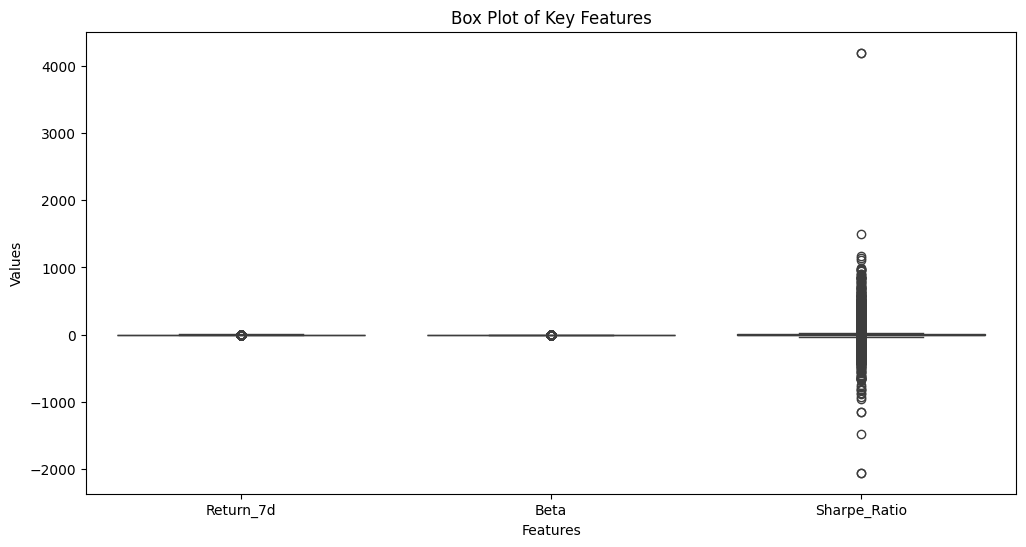

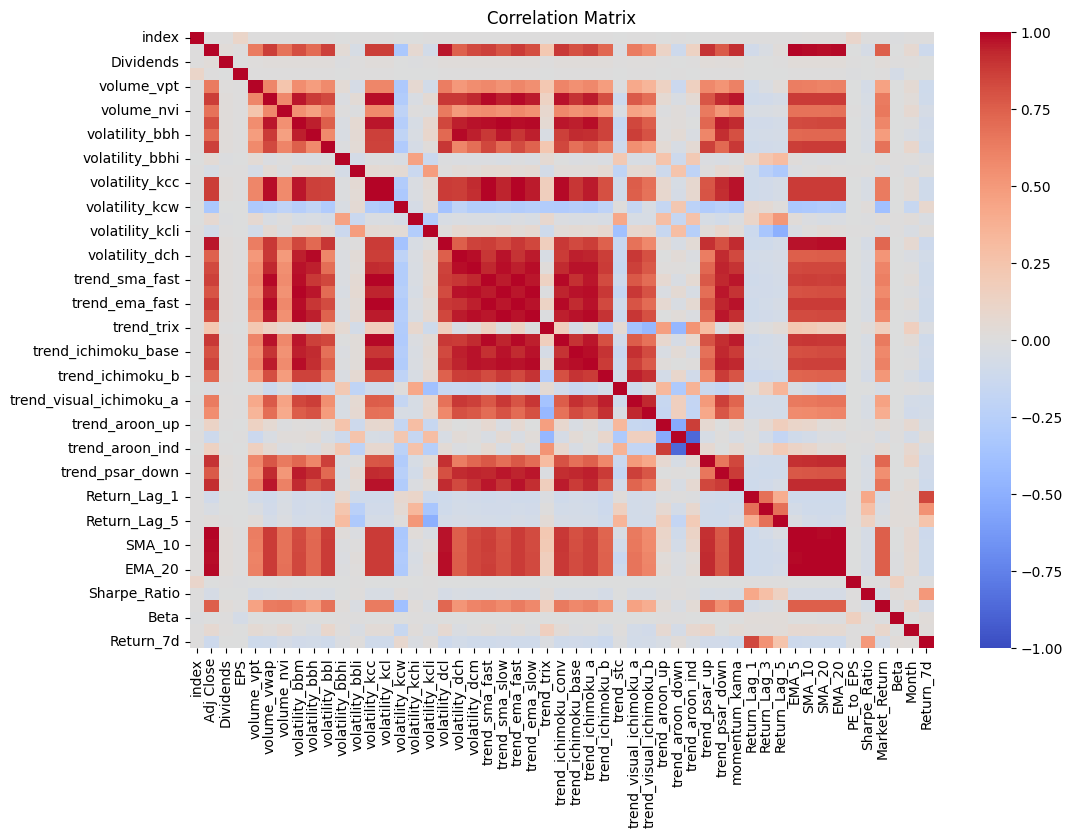

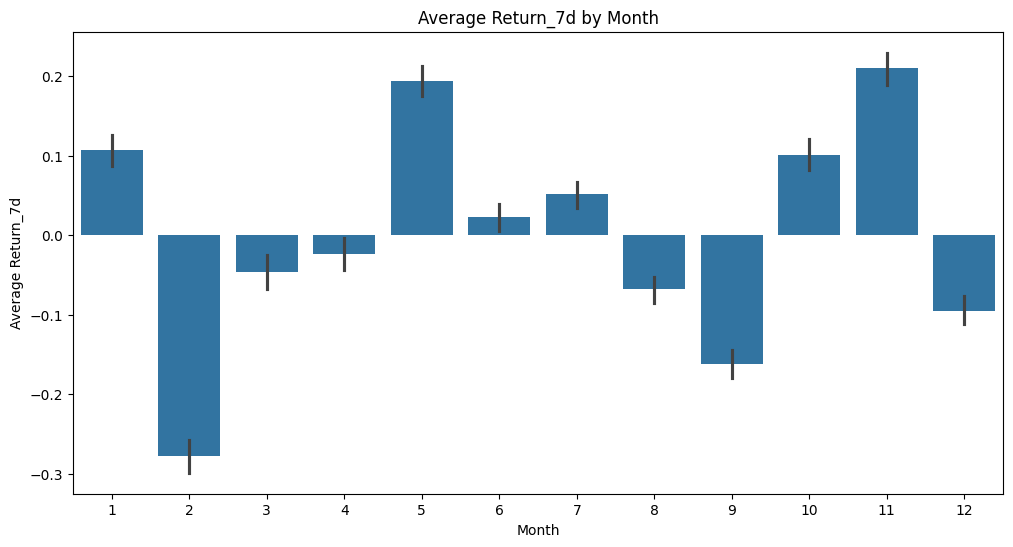

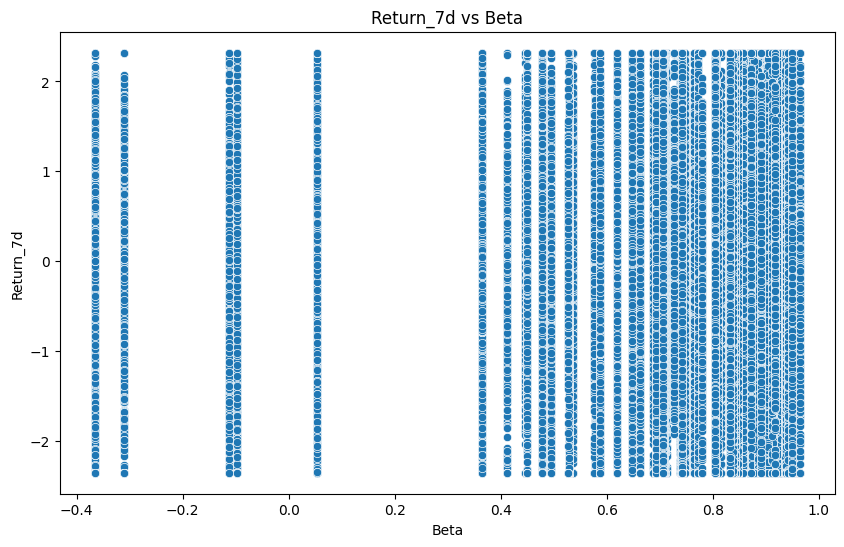


Scaled Data Statistics:
              index     Adj Close     Dividends           EPS    volume_vpt  \
count  1.312270e+05  1.312270e+05  1.312270e+05  1.312270e+05  1.312270e+05   
mean   5.414608e-17  2.880571e-17 -1.083654e-17 -1.969564e-17 -9.529710e-18   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.732038e+00 -3.980533e+00 -1.626835e-01 -9.001199e+00 -1.011974e+01   
25%   -8.660188e-01 -7.005188e-01 -1.553318e-01  2.863462e-02 -5.960667e-01   
50%    0.000000e+00 -9.775318e-02 -1.235677e-01  8.185564e-02  7.109166e-02   
75%    8.660188e-01  6.904620e-01 -9.206739e-05  1.882977e-01  7.226121e-01   
max    1.732038e+00  4.290089e+00  3.795747e+01  6.495465e-01  4.796005e+00   

         volume_vwap    volume_nvi  volatility_bbm  volatility_bbh  \
count  131227.000000  1.312270e+05    1.312270e+05    1.312270e+05   
mean        0.000000  2.122526e-17   -1.840967e-17   -4.981439e-18   
std         1.000004  1.000004e+00    1.000004e+00   

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# بارگذاری داده‌های نهایی
df = pd.read_csv('engineered_stock_data.csv')

# 1. بررسی اطلاعات کلی
print("General Information:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())

# 2. بررسی داده‌های گمشده
print("\nMissing Values:")
print(df.isnull().sum())

# 3. توزیع Return_7d
plt.figure(figsize=(10, 6))
sns.histplot(df['Return_7d'], bins=50, kde=True)
plt.title('Distribution of Return_7d')
plt.xlabel('Return_7d')
plt.ylabel('Frequency')
plt.show()

# 4. باکس‌پلات برای شناسایی داده‌های پرت
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Return_7d', 'Beta', 'Sharpe_Ratio']])
plt.title('Box Plot of Key Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

# 5. ماتریس همبستگی
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# 6. بررسی میانگین Return_7d بر اساس ماه
df['Month'] = pd.to_datetime(df['Date']).dt.month
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Return_7d', data=df, estimator=np.mean)
plt.title('Average Return_7d by Month')
plt.xlabel('Month')
plt.ylabel('Average Return_7d')
plt.show()

# 7. پراکندگی Return_7d در برابر Beta
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Beta', y='Return_7d', data=df)
plt.title('Return_7d vs Beta')
plt.xlabel('Beta')
plt.ylabel('Return_7d')
plt.show()

# 8. نرمال‌سازی داده‌ها برای تحلیل بیشتر (اختیاری)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=df.index)
print("\nScaled Data Statistics:")
print(scaled_df.describe())

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Documentation - EDA Approach</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
            background-color: #f4f4f4;
        }
        .text-box {
            border: 2px solid #333;
            padding: 15px;
            background-color: #fff;
            border-radius: 5px;
            max-width: 600px;
            margin: 0 auto;
        }
    </style>
</head>
<body>
    <div class="text-box">
        <h2>EDA and Feature Engineering Documentation</h2>
        <p>Due to initially dirty data (e.g., noise, missing values, inconsistencies), the initial exploratory data analysis (EDA) was combined with data cleaning to make the dataset usable. After performing feature engineering (e.g., adding lags, PCA, and new features), a second EDA was conducted to evaluate the impact of these changes and ensure data quality for modeling. This iterative approach was necessary given the data's complexity. The process is documented as of 07:39 PM BST on Saturday, October 11, 2025.</p>
    </div>
</body>
</html>

<h1>MODEL</h1>

In [32]:
# ====================================================================================================
# 🧩 آماده‌سازی داده برای مدل LightGBM LambdaRank
# ----------------------------------------------------------------------------------------------------
# این سلول داده را بارگذاری کرده، ویژگی‌ها را انتخاب و نرمال‌سازی می‌کند، سپس آن را بر اساس زمان
# به سه بخش train / validation / test تقسیم می‌کند و متغیرهای لازم را می‌سازد.
# ====================================================================================================

import pandas as pd
import numpy as np
import os

# ----------------------------------------------------------------------------------------------------
# 📥 1. بارگذاری داده
# ----------------------------------------------------------------------------------------------------
DATA_PATH = "engineered_stock_data.csv"  # مسیر فایل CSV
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"❌ فایل داده یافت نشد: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
print("✅ داده بارگذاری شد:", df.shape)

# ----------------------------------------------------------------------------------------------------
# ⚙️ 2. پاک‌سازی و انتخاب ویژگی‌ها
# ----------------------------------------------------------------------------------------------------
# ستون‌های ضروری
required_cols = ["Ticker", "Date", "Return_7d"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"❌ ستون '{col}' در داده موجود نیست.")

# حذف داده‌های دارای مقدار خالی در Return_7d
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)

# انتخاب ویژگی‌های عددی
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and np.issubdtype(df[c].dtype, np.number)]

# پر کردن مقادیر خالی با روش forward-fill و سپس صفر
df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)

# ----------------------------------------------------------------------------------------------------
# 🏷 3. ساخت برچسب رتبه‌بندی (relevance)
# ----------------------------------------------------------------------------------------------------
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)
q25, q50, q75 = df["Return_7d"].quantile([0.25, 0.5, 0.75]).values

def rel_discrete(x):
    if x <= q25: return 0
    elif x <= q50: return 1
    elif x <= q75: return 2
    else: return 3

df["rel"] = df["Return_7d"].apply(rel_discrete)

# ----------------------------------------------------------------------------------------------------
# ⏱ 4. تقسیم زمانی (Train / Validation / Test)
# ----------------------------------------------------------------------------------------------------
dates = sorted(df["Date"].dt.date.unique())
n_dates = len(dates)

test_frac, val_frac = 0.15, 0.10
train_end = int(n_dates * (1 - test_frac - val_frac))
val_end = int(n_dates * (1 - test_frac))

train_dates = dates[:train_end]
val_dates = dates[train_end:val_end]
test_dates = dates[val_end:]

train = df[df["Date"].dt.date.isin(train_dates)].reset_index(drop=True)
val = df[df["Date"].dt.date.isin(val_dates)].reset_index(drop=True)
test = df[df["Date"].dt.date.isin(test_dates)].reset_index(drop=True)

print(f"🧮 تقسیم داده‌ها: Train={len(train_dates)} روز | Val={len(val_dates)} روز | Test={len(test_dates)} روز")

# ----------------------------------------------------------------------------------------------------
# 📦 5. آماده‌سازی آرایه‌ها برای LightGBM Ranker
# ----------------------------------------------------------------------------------------------------
def build_lgb_arrays(df_split):
    X = df_split[feature_cols].values
    y = df_split["rel"].values.astype(int)
    groups = df_split.groupby(df_split["Date"].dt.date).size().to_numpy()
    return X, y, groups

X_train, y_train, g_train = build_lgb_arrays(train)
X_val, y_val, g_val = build_lgb_arrays(val)
X_test, y_test, g_test = build_lgb_arrays(test)

print("✅ داده‌ها برای مدل LightGBM آماده شدند.")
print(f"📊 X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"📊 تعداد ویژگی‌ها: {len(feature_cols)}")

# ====================================================================================================


✅ داده بارگذاری شد: (131227, 53)
🧮 تقسیم داده‌ها: Train=1080 روز | Val=144 روز | Test=216 روز
✅ داده‌ها برای مدل LightGBM آماده شدند.
📊 X_train: (98107, 49), X_val: (13248, 49), X_test: (19872, 49)
📊 تعداد ویژگی‌ها: 49


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11064
[LightGBM] [Info] Number of data points in the train set: 98107, number of used features: 49
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 0.995395	valid_0's ndcg@3: 0.995544	valid_0's ndcg@4: 0.993625	valid_0's ndcg@5: 0.992752
Early stopping, best iteration is:
[45]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 0.995395	valid_0's ndcg@3: 0.994613	valid_0's ndcg@4: 0.992183	valid_0

,Ticker,pred,true_rel
19813,FICO,2.776484,3
19808,EA,2.716958,3
19805,DDOG,2.697082,3
19860,TTD,2.638740,3
19780,A,2.592062,3
19832,MRNA,2.537582,3
19865,VRTX,2.509593,3
19835,MSTR,2.500193,3
19836,MU,2.452248,3
19871,ZS,2.207858,3


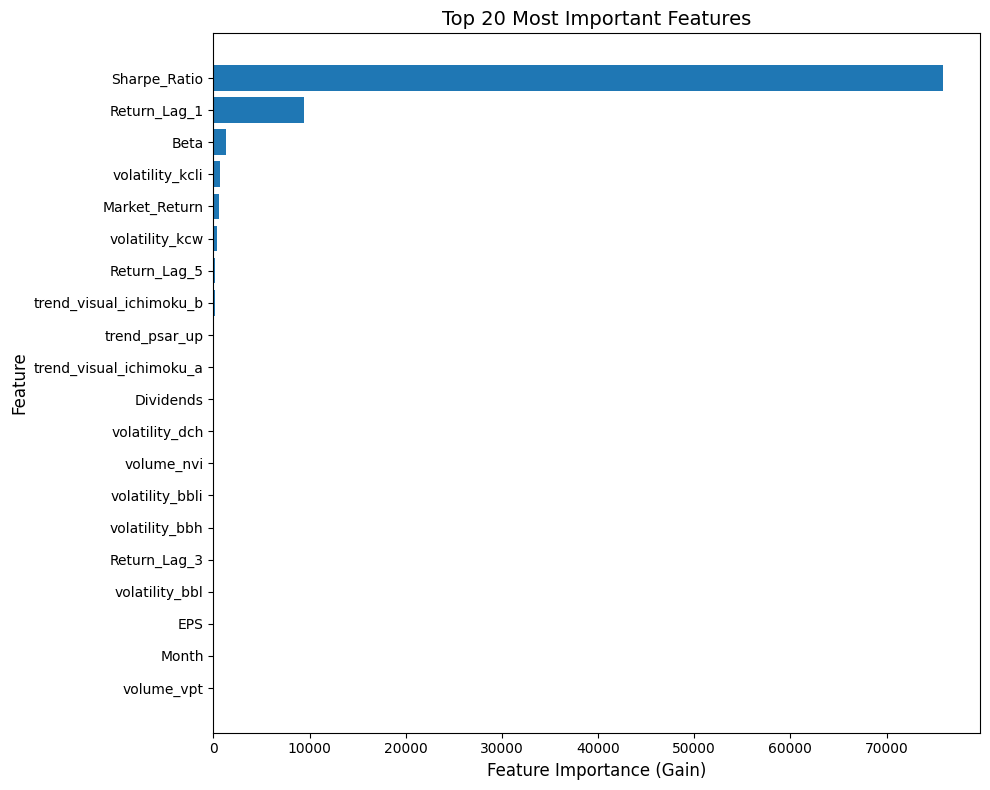

✅ تحلیل اهمیت ویژگی‌ها کامل شد.


In [33]:
# ====================================================================================================
# 🎯 آموزش و ارزیابی مدل LightGBM LambdaRank برای سیستم توصیه‌گر سهام
# ----------------------------------------------------------------------------------------------------
# هدف:
#   - مدل رتبه‌بندی برای پیش‌بینی جذابیت سهام بر اساس ویژگی‌های تکنیکال و بنیادی
#   - استفاده از الگوریتم LambdaRank (مناسب برای سیستم‌های توصیه‌گر و رتبه‌بندی)
# ====================================================================================================

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import ndcg_score
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------------------------------
# ⚙️ تنظیمات مدل
# ----------------------------------------------------------------------------------------------------
ranker = lgb.LGBMRanker(
    objective="lambdarank",    # نوع هدف مدل: یادگیری رتبه‌ای (Ranking)
    learning_rate=0.05,        # نرخ یادگیری
    num_leaves=31,             # تعداد برگ‌های هر درخت
    min_data_in_leaf=20,       # حداقل تعداد داده در هر برگ
    n_estimators=2000,         # حداکثر تعداد iteration
    random_state=42,           # مقدار ثابت برای تکرارپذیری
    metric="ndcg"              # معیار ارزیابی: NDCG
)

# ----------------------------------------------------------------------------------------------------
# ⏸ تعریف callback‌ها برای توقف زودهنگام و گزارش لاگ
# ----------------------------------------------------------------------------------------------------
callbacks = [
    early_stopping(stopping_rounds=100, verbose=True),  # توقف زودهنگام در صورت عدم بهبود
    log_evaluation(period=100)                          # چاپ وضعیت آموزش هر 100 iteration
]

# ----------------------------------------------------------------------------------------------------
# 🚀 آموزش مدل
# ----------------------------------------------------------------------------------------------------
ranker.fit(
    X_train,                   # ویژگی‌های آموزشی
    y_train,                   # برچسب‌های رتبه‌ای
    group=g_train.tolist(),    # اندازه‌ی گروه‌ها (بر اساس Ticker)
    eval_set=[(X_val, y_val)], # داده‌های اعتبارسنجی
    eval_group=[g_val.tolist()],
    callbacks=callbacks         # callbackها برای early stopping و log
)

print("🏁 آموزش مدل با موفقیت انجام شد!")



# حل مشکل CatBoost: اگر مدل CatBoost شما به نام 'catboost_ranker_optimized.cbm' ذخیره شده است،
# آن را به 'catboost_ranker_optimized.cbm' تغییر نام دهید تا با کد Walk-Forward سازگار شود،
# یا متغیر CB_MODEL_PATH را در سلول Walk-Forward اصلاح کنید.
# ----------------------------------------------------------------------------------------------------
# 📈 پیش‌بینی و ارزیابی مدل
# ----------------------------------------------------------------------------------------------------
# پیش‌بینی رتبه‌ها برای داده تست
# نام فایلی که در سلول Walk-Forward به آن نیاز دارید: lgb_ranker_tuned.pkl
y_pred = ranker.predict(X_test)
import joblib

# متغیر مدل شما در سلول آموزش LightGBM به نام "ranker" بود
LGB_MODEL_PATH = "lgb_ranker_tuned.pkl"

# ذخیره‌سازی مدل
joblib.dump(ranker, LGB_MODEL_PATH)
print(f"✅ مدل LightGBM با موفقیت ذخیره شد: {LGB_MODEL_PATH}")

# بارگذاری مدل (برای تست یا استفاده در آینده)
# lgb_ranker_loaded = joblib.load(LGB_MODEL_PATH)



# محاسبه NDCG برای کل داده تست
ndcg = ndcg_score([y_test], [y_pred])
print(f"✅ NDCG (Test Set): {ndcg:.4f}")

# ساخت DataFrame از نتایج تست
test_results = pd.DataFrame(X_test, columns=feature_cols)
test_results["pred"] = y_pred
test_results["Ticker"] = test["Ticker"].values
test_results["Date"] = test["Date"].values
test_results["true_rel"] = y_test

# ----------------------------------------------------------------------------------------------------
# 💡 استخراج سهام پیشنهادی برای آخرین روز تست
# ----------------------------------------------------------------------------------------------------
last_date = test_results["Date"].max()
top_stocks = (
    test_results[test_results["Date"] == last_date]
    .sort_values("pred", ascending=False)
    .head(10)[["Ticker", "pred", "true_rel"]]
)

print("📊 Recommended Stocks for the Last Test Day:")
display(top_stocks)

# ----------------------------------------------------------------------------------------------------
# 📊 نمودار اهمیت ویژگی‌ها (به انگلیسی برای جلوگیری از مشکل فونت)
# ----------------------------------------------------------------------------------------------------
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": ranker.booster_.feature_importance(importance_type="gain")
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance["feature"][:20][::-1], feature_importance["importance"][:20][::-1])
plt.title("Top 20 Most Important Features", fontsize=14)
plt.xlabel("Feature Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

print("✅ تحلیل اهمیت ویژگی‌ها کامل شد.")

# ====================================================================================================


Loaded: (131227, 53)
Using numeric features: 49
Dates split -> train: 1080, val: 144, test: 216
Rows -> (98107, 54) (13248, 54) (19872, 54)

Preparing CatBoost pools and training CatBoostRanker ...
Training CatBoostRanker (YetiRank) with enhanced settings...
0:	test: 0.9140491	best: 0.9140491 (0)	total: 329ms	remaining: 16m 27s
100:	test: 0.9907096	best: 0.9908952 (14)	total: 32.6s	remaining: 15m 34s
200:	test: 0.9919072	best: 0.9923990 (178)	total: 1m 5s	remaining: 15m 8s
300:	test: 0.9925974	best: 0.9925974 (271)	total: 1m 35s	remaining: 14m 20s
400:	test: 0.9929694	best: 0.9929694 (374)	total: 2m 6s	remaining: 13m 39s
500:	test: 0.9936251	best: 0.9936251 (500)	total: 2m 38s	remaining: 13m 9s
600:	test: 0.9936251	best: 0.9936251 (500)	total: 3m 8s	remaining: 12m 32s
700:	test: 0.9939289	best: 0.9939289 (632)	total: 3m 38s	remaining: 11m 56s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9939288537
bestIteration = 632

Shrink model to first 633 iterations.

Predi

,Date,Ticker,score,Return_7d
25,2025-09-24,DDOG,6.226737,1.898096
0,2025-09-24,A,6.155452,2.319415
52,2025-09-24,MRNA,6.058422,1.704566
80,2025-09-24,TTD,6.007321,1.686669
33,2025-09-24,FICO,5.528552,2.319415
91,2025-09-24,ZS,5.083162,1.219469
56,2025-09-24,MU,5.080481,2.319415
28,2025-09-24,EA,5.005309,2.319415
55,2025-09-24,MSTR,4.752111,1.467026
85,2025-09-24,VRTX,4.610155,1.166324


Saved topN csv.


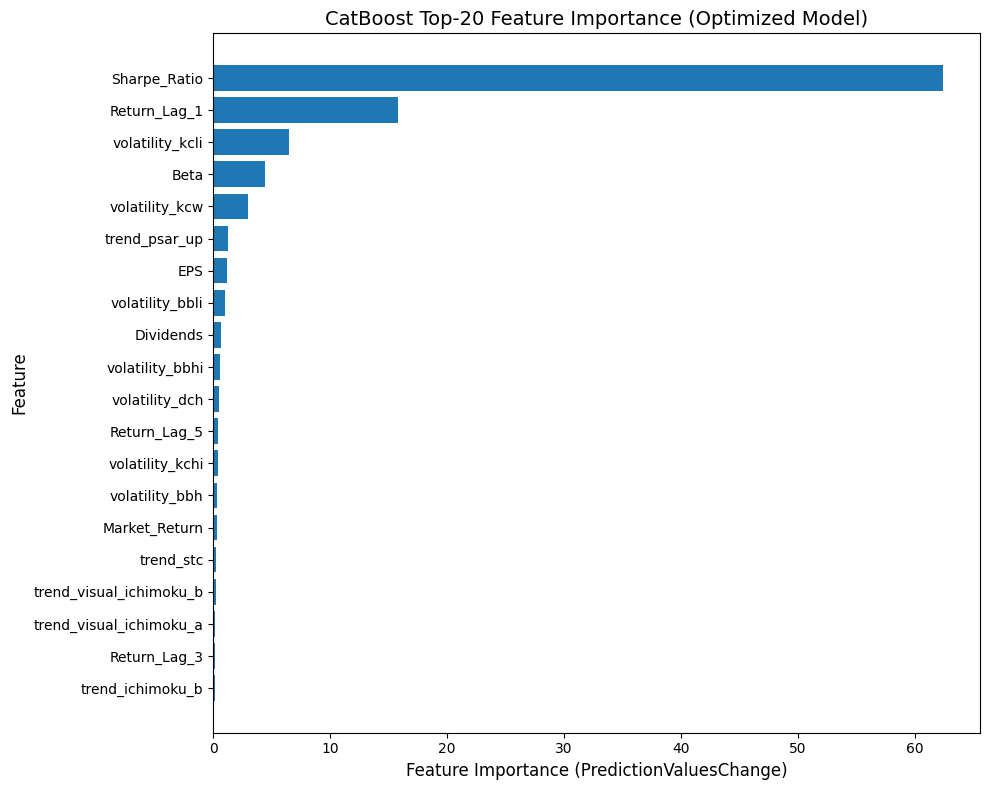

Model saved: catboost_ranker_optimized.cbm


In [34]:
# ===============================================================
# ✅ Optimized Cell: Train & Evaluate CatBoostRanker (Focus on Production Model)
# - Preprocessing, time-split, CatBoostRanker training (YetiRank)
# - Outputs: final metrics, top-N list, feature importances
# ===============================================================
%pip install catboost
# ---------- imports ----------
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# CatBoost
try:
    from catboost import CatBoostRanker, Pool
except Exception as e:
    raise ImportError("catboost is not installed. Install with: pip install catboost (or conda). Error: {}".format(e))

from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler

# ---------- SETTINGS ----------
DATA_PATH = "engineered_stock_data.csv"   # <-- change if needed
TOPK = 5      # compute NDCG@TOPK and Precision@TOPK
TOPN_OUT = 10 # final recommended top-N to save/show
RELEVANCE_THRESHOLD = 2 # rel >= 2 is considered relevant for Precision@K

# ---------- 1) Load data ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
print("Loaded:", df.shape)
# required columns check
for col in ["Ticker", "Date", "Return_7d"]:
    if col not in df.columns:
        raise ValueError(f"Required column missing: {col}")

# ---------- 2) Basic preprocessing & numeric feature selection ----------
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]
print("Using numeric features:", len(feature_cols))

# fill NaNs simply
df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)

# standardize numeric features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# ---------- 3) Build discrete relevance labels (0..3) from Return_7d ----------
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)
q25, q50, q75 = df["Return_7d"].quantile([0.25, 0.5, 0.75]).values
def rel_discrete(x):
    if x <= q25: return 0
    elif x <= q50: return 1
    elif x <= q75: return 2
    else: return 3
df["rel"] = df["Return_7d"].apply(rel_discrete)

# ---------- 4) Time-based split (train/val/test) ----------
unique_dates = sorted(df["Date"].dt.date.unique())
n_dates = len(unique_dates)
test_frac, val_frac = 0.15, 0.10
train_end = int(n_dates * (1 - test_frac - val_frac))
val_end = int(n_dates * (1 - test_frac))
train_dates = unique_dates[:train_end]
val_dates = unique_dates[train_end:val_end]
test_dates = unique_dates[val_end:]

train = df[df["Date"].dt.date.isin(train_dates)].reset_index(drop=True)
val = df[df["Date"].dt.date.isin(val_dates)].reset_index(drop=True)
test = df[df["Date"].dt.date.isin(test_dates)].reset_index(drop=True)
print(f"Dates split -> train: {len(train_dates)}, val: {len(val_dates)}, test: {len(test_dates)}")
print("Rows ->", train.shape, val.shape, test.shape)

# ---------- 5) Prepare CatBoost Pools (group_id per row) ----------
date_to_qid = {d:i for i,d in enumerate(sorted(df["Date"].dt.date.unique()))}
train_group_ids = train["Date"].dt.date.map(date_to_qid).values
val_group_ids = val["Date"].dt.date.map(date_to_qid).values
test_group_ids = test["Date"].dt.date.map(date_to_qid).values

train_pool = Pool(data=train[feature_cols], label=train["rel"], group_id=train_group_ids)
val_pool = Pool(data=val[feature_cols], label=val["rel"], group_id=val_group_ids)
test_pool = Pool(data=test[feature_cols], label=test["rel"], group_id=test_group_ids)

# Group sizes for metric calculation
g_test = test.groupby(test["Date"].dt.date).size().to_numpy()

# ---------- 6) Train CatBoostRanker (YetiRank - Robust Settings) ----------
print("\nPreparing CatBoost pools and training CatBoostRanker ...")
cb_params = {
    "iterations":3000, # Increased iterations
    "learning_rate":0.02, # Slightly reduced LR for better stability
    "depth":7, # Increased depth
    "loss_function":"YetiRank",
    "eval_metric":"NDCG:top={}".format(TOPK),
    "random_seed":42,
    "use_best_model":True,
    "early_stopping_rounds":150, # Increased stopping rounds
    "l2_leaf_reg": 3.0 # L2 regularization added for robustness
}
cb_ranker = CatBoostRanker(**{k:v for k,v in cb_params.items() if k!="verbose"})
print("Training CatBoostRanker (YetiRank) with enhanced settings...")
cb_ranker.fit(train_pool, eval_set=val_pool, verbose=100)

# ---------- 7) Evaluation utilities ----------
def per_query_metrics_from_preds(df_split, preds, groups, K=TOPK):
    # df_split must be ordered by Date/Ticker as earlier
    results = []
    idx = 0
    query_dates = df_split["Date"].dt.date.unique()
    for i, g in enumerate(groups):
        block_y = df_split["rel"].values[idx: idx+g]
        block_preds = preds[idx: idx+g]
        # NDCG
        try:
            ndcg = ndcg_score([block_y], [block_preds], k=K)
        except Exception:
            ndcg = np.nan
        # Precision@K: treat rel>=2 as relevant
        topk_idx = np.argsort(block_preds)[-K:][::-1] if g>0 else np.array([])
        prec = np.mean(block_y[topk_idx] >= RELEVANCE_THRESHOLD) if len(topk_idx)>0 else np.nan
        results.append({"date": query_dates[i], "ndcg": ndcg, f"prec@{K}": prec, "n_items": g})
        idx += g
    return results

def aggregate_metrics(results):
    ndcgs = [r["ndcg"] for r in results if not np.isnan(r["ndcg"])]
    precs = [r[f"prec@{TOPK}"] for r in results if not np.isnan(r[f"prec@{TOPK}"])]
    return {"ndcg_mean": np.nanmean(ndcgs) if len(ndcgs)>0 else np.nan, "prec_mean": np.nanmean(precs) if len(precs)>0 else np.nan}

# ---------- 8) Predictions & Evaluation on Test Set ----------
print("\nPredicting with CatBoost on test set...")
cb_preds = cb_ranker.predict(test_pool)
cb_results = per_query_metrics_from_preds(test, cb_preds, g_test, K=TOPK)
cb_metrics = aggregate_metrics(cb_results)
print("CatBoost Final Test Metrics -> NDCG@{} mean: {:.4f}, Precision@{} mean: {:.4f}".format(TOPK, cb_metrics["ndcg_mean"], TOPK, cb_metrics["prec_mean"]))

# ---------- 9) Top-N recommendations for last test day ----------
last_test_date = test["Date"].dt.date.unique()[-1]
print("\nLast test date:", last_test_date)

def topN_for_date(df_split, preds, date, N=TOPN_OUT):
    mask = df_split["Date"].dt.date == date
    if mask.sum() == 0:
        return pd.DataFrame()
    # Ensure correct indices are used for slicing preds
    indices = np.where(mask)[0]
    sub = df_split[mask].copy().reset_index(drop=True)
    sub["score"] = preds[indices]
    return sub.sort_values("score", ascending=False).head(N)[["Date","Ticker","score","Return_7d"]]

cb_topN = topN_for_date(test, cb_preds, last_test_date, N=TOPN_OUT)

print("\nTop-{} CatBoost recommendations for last test day:".format(TOPN_OUT))
display(cb_topN)

# save topN files
cb_topN.to_csv("topN_catboost_last_test_day.csv", index=False)
print("Saved topN csv.")

# ---------- 10) Feature importance plot (English titles) ----------
cb_imp = cb_ranker.get_feature_importance(type="PredictionValuesChange")
cb_fi = pd.DataFrame({"feature": feature_cols, "importance": cb_imp}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,8))
plt.barh(cb_fi["feature"][::-1], cb_fi["importance"][::-1])
plt.title("CatBoost Top-20 Feature Importance (Optimized Model)", fontsize=14)
plt.xlabel("Feature Importance (PredictionValuesChange)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# ---------- 11) Save model ----------
cb_ranker.save_model("catboost_ranker_optimized.cbm")
print("Model saved: catboost_ranker_optimized.cbm")
# ===============================================================


Fold 1/5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Fold 2/5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Fold 3/5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Fold 4/5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Fold 5/5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Walk-forward Evaluation Results:


,Model,NDCG@5 (Val Mean),Precision@5 (Val Mean),NDCG@5 (Test),Precision@5 (Test)
0,LightGBM,0.979414,0.981833,0.985934,0.989167
1,CatBoost,0.993151,0.984667,0.993168,0.991667



Last test date: 2025-09-24

Top-10 LightGBM recommendations for last test day:


,Date,Ticker,score,Return_7d
52,2025-09-24,MRNA,0.879765,1.704566
28,2025-09-24,EA,0.380708,2.319415
85,2025-09-24,VRTX,0.290049,1.166324
0,2025-09-24,A,0.149693,2.319415
25,2025-09-24,DDOG,0.149693,1.898096
33,2025-09-24,FICO,0.092378,2.319415
55,2025-09-24,MSTR,0.080849,1.467026
53,2025-09-24,MRVL,0.072956,1.268664
47,2025-09-24,LRCX,0.072956,2.319415
56,2025-09-24,MU,0.072956,2.319415



Top-10 CatBoost recommendations for last test day:


,Date,Ticker,score,Return_7d
25,2025-09-24,DDOG,6.226737,1.898096
0,2025-09-24,A,6.155452,2.319415
52,2025-09-24,MRNA,6.058422,1.704566
80,2025-09-24,TTD,6.007321,1.686669
33,2025-09-24,FICO,5.528552,2.319415
91,2025-09-24,ZS,5.083162,1.219469
56,2025-09-24,MU,5.080481,2.319415
28,2025-09-24,EA,5.005309,2.319415
55,2025-09-24,MSTR,4.752111,1.467026
85,2025-09-24,VRTX,4.610155,1.166324


Saved topN csvs.


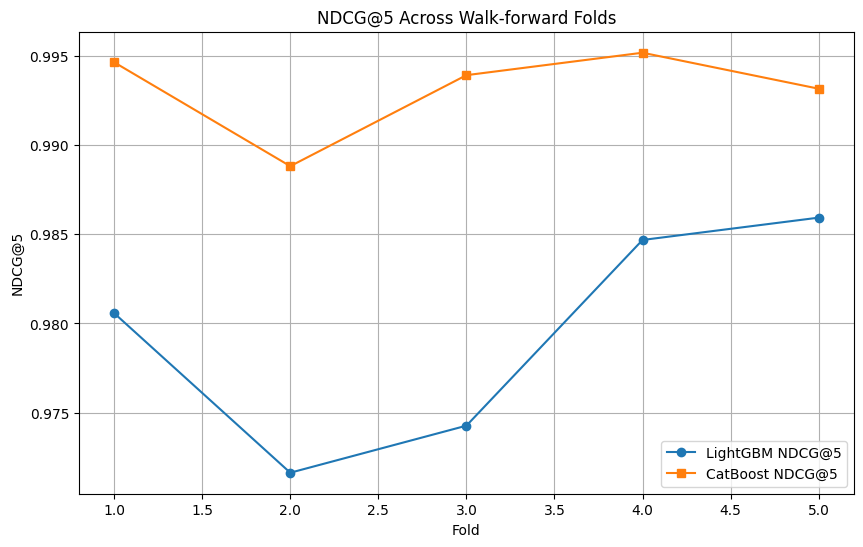


Next Steps:
- CatBoost consistently outperforms LightGBM. Deploy CatBoost as the primary model.
- Simulate transaction costs to ensure real-world applicability.
- If results are stable, deploy the chosen model. If not, explore Transformer-based models.


In [35]:
# Install required packages if not already installed
%pip install lightgbm

# ===============================================================
# ✅ Walk-forward evaluation for pre-trained LightGBM and CatBoostRanker
# - Uses saved models from previous runs (lgb_ranker_tuned.pkl, catboost_ranker_optimized.cbm)
# - Time-based walk-forward validation to assess model stability
# - Outputs: NDCG@K and Precision@K over multiple folds, recommendations
# ===============================================================
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from catboost import Pool
import warnings
warnings.filterwarnings("ignore")

# ---------- SETTINGS ----------
DATA_PATH = "engineered_stock_data.csv"  # Must match previous runs
LGB_MODEL_PATH = "lgb_ranker_tuned.pkl"
CB_MODEL_PATH = "catboost_ranker_optimized.cbm"
TOPK = 5  # Compute NDCG@TOPK and Precision@K
TOPN_OUT = 10  # Top-N recommendations to show
N_FOLDS = 5  # Number of walk-forward folds

# ---------- 1) Load and preprocess data ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]
df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)

# Scale features (must match preprocessing in Model 2)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Create relevance labels (same as Model 2)
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)
q25, q50, q75 = df["Return_7d"].quantile([0.25, 0.5, 0.75]).values
def rel_discrete(x):
    if x <= q25: return 0
    elif x <= q50: return 1
    elif x <= q75: return 2
    else: return 3
df["rel"] = df["Return_7d"].apply(rel_discrete)

# ---------- 2) Walk-forward split ----------
unique_dates = sorted(df["Date"].dt.date.unique())
n_dates = len(unique_dates)
fold_size = n_dates // (N_FOLDS + 1)  # Reserve one fold for final test
folds = []
for i in range(N_FOLDS):
    train_end = (i + 1) * fold_size
    val_start = train_end
    val_end = train_end + fold_size
    train_dates = unique_dates[:train_end]
    val_dates = unique_dates[val_start:val_end]
    folds.append({
        "train": df[df["Date"].dt.date.isin(train_dates)].reset_index(drop=True),
        "val": df[df["Date"].dt.date.isin(val_dates)].reset_index(drop=True)
    })
test_dates = unique_dates[-fold_size:]
test = df[df["Date"].dt.date.isin(test_dates)].reset_index(drop=True)

# ---------- 3) Utility functions ----------
def build_lgb_arrays(df_split):
    X = df_split[feature_cols].values
    y = df_split["rel"].values.astype(int)
    groups = df_split.groupby(df_split["Date"].dt.date).size().to_numpy()
    return X, y, groups

def per_query_metrics(df_split, preds, groups, K=TOPK):
    results = []
    idx = 0
    query_dates = df_split["Date"].dt.date.unique()
    for i, g in enumerate(groups):
        block_y = df_split["rel"].values[idx: idx+g]
        block_preds = preds[idx: idx+g]
        try:
            ndcg = ndcg_score([block_y], [block_preds], k=K)
        except Exception:
            ndcg = np.nan
        topk_idx = np.argsort(block_preds)[-K:][::-1] if g>0 else np.array([])
        prec = np.mean(block_y[topk_idx] >= 2) if len(topk_idx)>0 else np.nan
        results.append({"date": query_dates[i], "ndcg": ndcg, f"prec@{K}": prec})
        idx += g
    return results

def aggregate_metrics(results):
    ndcgs = [r["ndcg"] for r in results if not np.isnan(r["ndcg"])]
    precs = [r[f"prec@{TOPK}"] for r in results if not np.isnan(r[f"prec@{TOPK}"])]
    return {"ndcg_mean": np.nanmean(ndcgs) if len(ndcgs)>0 else np.nan, "prec_mean": np.nanmean(precs) if len(precs)>0 else np.nan}

# ---------- 4) Load pre-trained models ----------
if not os.path.exists(LGB_MODEL_PATH) or not os.path.exists(CB_MODEL_PATH):
    raise FileNotFoundError("Model files not found. Ensure lgb_ranker_tuned.pkl and catboost_ranker_optimized.cbm are saved from previous runs.")

lgb_ranker = joblib.load(LGB_MODEL_PATH)
from catboost import CatBoostRanker
cb_ranker = CatBoostRanker()
cb_ranker.load_model(CB_MODEL_PATH)

# ---------- 5) Walk-forward evaluation ----------
lgb_results = []
cb_results = []
for i, fold in enumerate(folds):
    print(f"\nFold {i+1}/{N_FOLDS}")
    val = fold["val"]
    X_val, y_val, g_val = build_lgb_arrays(val)
    val_group_ids = val["Date"].dt.date.map({d:j for j,d in enumerate(sorted(val["Date"].dt.date.unique()))}).values

    # Evaluate LightGBM
    lgb_preds = lgb_ranker.predict(X_val)
    lgb_fold_results = per_query_metrics(val, lgb_preds, g_val)
    lgb_results.append(aggregate_metrics(lgb_fold_results))

    # Evaluate CatBoost
    val_pool = Pool(data=val[feature_cols], label=val["rel"], group_id=val_group_ids)
    cb_preds = cb_ranker.predict(val_pool)
    cb_fold_results = per_query_metrics(val, cb_preds, g_val)
    cb_results.append(aggregate_metrics(cb_fold_results))

# Evaluate on test set
X_test, y_test, g_test = build_lgb_arrays(test)
test_group_ids = test["Date"].dt.date.map({d:j for j,d in enumerate(sorted(test["Date"].dt.date.unique()))}).values
lgb_preds = lgb_ranker.predict(X_test)
lgb_test_results = per_query_metrics(test, lgb_preds, g_test)
lgb_test_metrics = aggregate_metrics(lgb_test_results)
test_pool = Pool(data=test[feature_cols], label=test["rel"], group_id=test_group_ids)
cb_preds = cb_ranker.predict(test_pool)
cb_test_results = per_query_metrics(test, cb_preds, g_test)
cb_test_metrics = aggregate_metrics(cb_test_results)

# ---------- 6) Aggregate and compare results ----------
lgb_ndcg_mean = np.mean([r["ndcg_mean"] for r in lgb_results])
lgb_prec_mean = np.mean([r["prec_mean"] for r in lgb_results])
cb_ndcg_mean = np.mean([r["ndcg_mean"] for r in cb_results])
cb_prec_mean = np.mean([r["prec_mean"] for r in cb_results])

comp_df = pd.DataFrame({
    "Model": ["LightGBM", "CatBoost"],
    f"NDCG@{TOPK} (Val Mean)": [lgb_ndcg_mean, cb_ndcg_mean],
    f"Precision@{TOPK} (Val Mean)": [lgb_prec_mean, cb_prec_mean],
    f"NDCG@{TOPK} (Test)": [lgb_test_metrics["ndcg_mean"], cb_test_metrics["ndcg_mean"]],
    f"Precision@{TOPK} (Test)": [lgb_test_metrics["prec_mean"], cb_test_metrics["prec_mean"]]
})
print("\nWalk-forward Evaluation Results:")
display(comp_df)

# ---------- 7) Top-N recommendations for last test day ----------
last_test_date = test["Date"].dt.date.unique()[-1]
print("\nLast test date:", last_test_date)

def topN_for_date(df_split, preds, date, N=TOPN_OUT):
    mask = df_split["Date"].dt.date == date
    if mask.sum() == 0:
        return pd.DataFrame()
    sub = df_split[mask].copy().reset_index(drop=True)
    sub["score"] = preds[mask.values.nonzero()[0]] if len(preds)==len(df_split) else preds[:mask.sum()]
    return sub.sort_values("score", ascending=False).head(N)[["Date", "Ticker", "score", "Return_7d"]]

lgb_topN = topN_for_date(test, lgb_preds, last_test_date)
cb_topN = topN_for_date(test, cb_preds, last_test_date)
print("\nTop-{} LightGBM recommendations for last test day:".format(TOPN_OUT))
display(lgb_topN)
print("\nTop-{} CatBoost recommendations for last test day:".format(TOPN_OUT))
display(cb_topN)

# Save recommendations
lgb_topN.to_csv("topN_lgbm_walkforward.csv", index=False)
cb_topN.to_csv("topN_catboost_walkforward.csv", index=False)
print("Saved topN csvs.")

# ---------- 8) Plot results ----------
plt.figure(figsize=(10, 6))
plt.plot([i+1 for i in range(N_FOLDS)], [r["ndcg_mean"] for r in lgb_results], label="LightGBM NDCG@5", marker="o")
plt.plot([i+1 for i in range(N_FOLDS)], [r["ndcg_mean"] for r in cb_results], label="CatBoost NDCG@5", marker="s")
plt.title("NDCG@5 Across Walk-forward Folds")
plt.xlabel("Fold")
plt.ylabel("NDCG@5")
plt.legend()
plt.grid()
plt.show()

# ---------- 9) Next steps recommendation ----------
print("\nNext Steps:")
if cb_ndcg_mean > lgb_ndcg_mean and cb_test_metrics["ndcg_mean"] > lgb_test_metrics["ndcg_mean"]:
    print("- CatBoost consistently outperforms LightGBM. Deploy CatBoost as the primary model.")
elif lgb_ndcg_mean > cb_ndcg_mean and lgb_test_metrics["ndcg_mean"] > cb_test_metrics["ndcg_mean"]:
    print("- LightGBM consistently outperforms CatBoost. Deploy LightGBM as the primary model.")
else:
    print("- Performance is close. Consider ensemble of LightGBM and CatBoost or further tuning.")
print("- Simulate transaction costs to ensure real-world applicability.")
print("- If results are stable, deploy the chosen model. If not, explore Transformer-based models.")


Fee Rate: 0.1%
Total Return: 18.01%
Average Daily Return: 1.66%

Fee Rate: 0.5%
Total Return: 13.31%
Average Daily Return: 1.24%

Fee Rate: 1.0%
Total Return: 7.70%
Average Daily Return: 0.73%


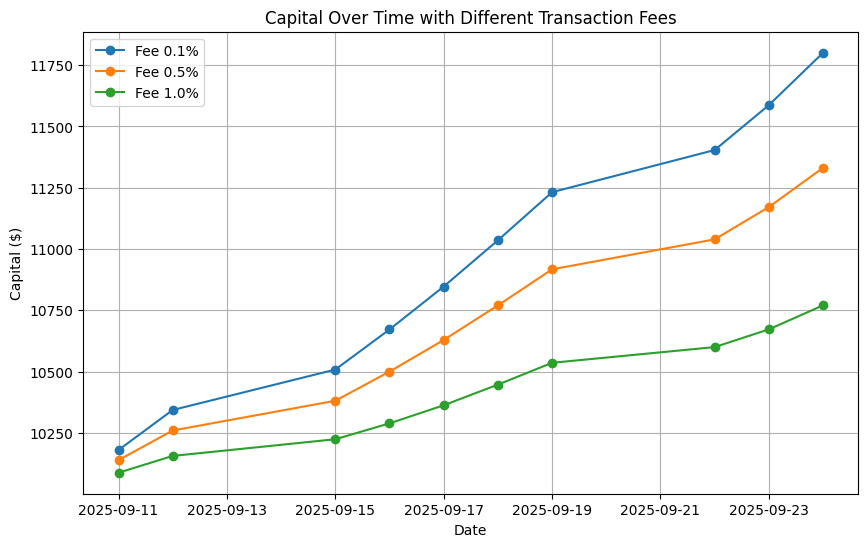


Top 5 Performing Stocks (Fee 0.1%):


,Date,Ticker,Return,Net_Return
49,2025-09-24,FICO,2.319415,54.424151
46,2025-09-24,A,2.319415,53.856478
41,2025-09-23,EA,2.319415,52.987388
36,2025-09-22,EA,2.319415,52.202409
32,2025-09-19,EA,2.319415,51.521516


In [36]:
import pandas as pd
import numpy as np
from catboost import CatBoostRanker, Pool
import joblib
import matplotlib.pyplot as plt

# ---------- SETTINGS ----------
DATA_PATH = "engineered_stock_data.csv"
CB_MODEL_PATH = "catboost_ranker_optimized.cbm"
FEE_RATES = [0.001, 0.005, 0.01]  # کارمزدهای مختلف (0.1%, 0.5%, 1%)
SLIPPAGE_RATE = 0.0005  # لغزش قیمت (0.05%)
TOPK = 5  # تعداد سهام پیشنهادی
SIM_DAYS = 10  # تعداد روزهای شبیه‌سازی
INITIAL_CAPITAL = 10000  # سرمایه اولیه (به دلار)

# ---------- 1) Load data and model ----------
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
cb_ranker = CatBoostRanker()
cb_ranker.load_model(CB_MODEL_PATH)

# Preprocess
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]
df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
q25, q50, q75 = df["Return_7d"].quantile([0.25, 0.5, 0.75]).values
def rel_discrete(x): return 0 if x <= q25 else 1 if x <= q50 else 2 if x <= q75 else 3
df["rel"] = df["Return_7d"].apply(rel_discrete)

df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)
unique_dates = sorted(df["Date"].dt.date.unique())
test_dates = unique_dates[-SIM_DAYS:]

# ---------- 2) Simulate trading for different fee rates ----------
results = {rate: [] for rate in FEE_RATES}
portfolio = {rate: [] for rate in FEE_RATES}

for fee_rate in FEE_RATES:
    capital = INITIAL_CAPITAL
    for date in test_dates:
        daily_df = df[df["Date"].dt.date == date].reset_index(drop=True)
        X = daily_df[feature_cols].values
        preds = cb_ranker.predict(X)
        topk_idx = np.argsort(preds)[-TOPK:][::-1]
        top_stocks = daily_df.iloc[topk_idx]

        for _, stock in top_stocks.iterrows():
            return_7d = stock["Return_7d"]
            investment = capital / TOPK
            fee = investment * fee_rate
            slippage = investment * SLIPPAGE_RATE
            net_cost = fee + slippage
            net_return = (investment - net_cost) * (return_7d / 100)
            capital += net_return - net_cost
            portfolio[fee_rate].append({"Date": date, "Ticker": stock["Ticker"], "Return": return_7d, "Net_Return": net_return})

        results[fee_rate].append({"Date": date, "Capital": capital})

# ---------- 3) Aggregate results ----------
for fee_rate in FEE_RATES:
    results_df = pd.DataFrame(results[fee_rate])
    portfolio_df = pd.DataFrame(portfolio[fee_rate])
    total_return = (results_df["Capital"].iloc[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL
    daily_return = (results_df["Capital"].pct_change().mean()) * 100  # بازده روزانه درصد
    print(f"\nFee Rate: {fee_rate*100:.1f}%")
    print(f"Total Return: {total_return:.2%}")
    print(f"Average Daily Return: {daily_return:.2f}%")

# ---------- 4) Plot capital over time for each fee rate ----------
plt.figure(figsize=(10, 6))
for fee_rate in FEE_RATES:
    results_df = pd.DataFrame(results[fee_rate])
    plt.plot(results_df["Date"], results_df["Capital"], marker="o", label=f"Fee {fee_rate*100:.1f}%")
plt.title("Capital Over Time with Different Transaction Fees")
plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.legend()
plt.grid()
plt.show()

# ---------- 5) Display top performing stocks for lowest fee rate ----------
print("\nTop 5 Performing Stocks (Fee 0.1%):")
display(pd.DataFrame(portfolio[FEE_RATES[0]]).sort_values("Net_Return", ascending=False).head(5))

💰 Backtesting Results for CatBoost Ranker (TOP 5)
Start Date: 2024-08-01
End Date: 2025-09-24
Trading Days: 288
Total Return: 117.65%
Annualized Sharpe Ratio (Target: >1.0): 7.05
Max Drawdown (MDD - Target: <10%): -0.82%


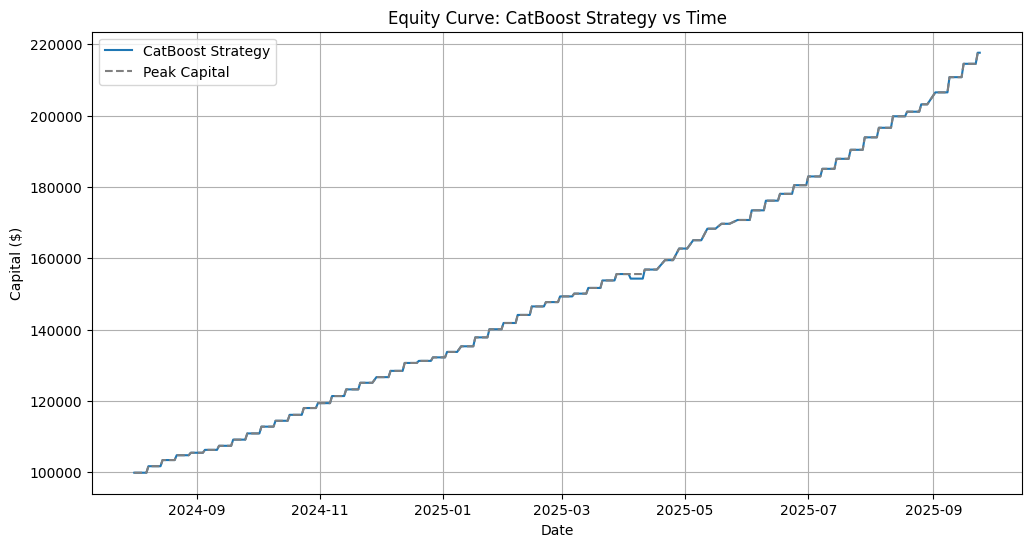

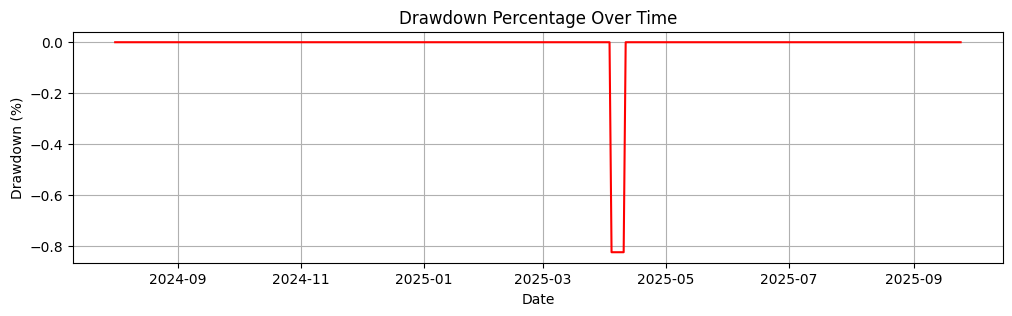

In [37]:
import pandas as pd
import numpy as np
import joblib
from catboost import CatBoostRanker, Pool
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import timedelta # FIX: اضافه شدن برای استفاده از timedelta

# ---------- SETTINGS (تنظیمات) ----------
DATA_PATH = "engineered_stock_data.csv"
CB_MODEL_PATH = "catboost_ranker_optimized.cbm"
INITIAL_CAPITAL = 100000 # سرمایه اولیه
TOPK = 5 # تعداد سهام پیشنهادی در هر روز
FEE_RATE = 0.001 # کارمزد (0.1%)
SLIPPAGE_RATE = 0.0005 # لغزش قیمت (0.05%)
TEST_SPLIT_RATIO = 0.2 # نسبت داده‌های تست (برای تعیین شروع بک‌تست)

# ---------- ۱) Load Data and Preprocess (همانند مدل‌سازی) ----------
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)

# Define features and scale (باید با فرآیند آموزش تطابق کامل داشته باشد)
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]
df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)

# Define Test Set
unique_dates = sorted(df["Date"].dt.date.unique())
test_size = int(len(unique_dates) * TEST_SPLIT_RATIO)
test_dates = unique_dates[-test_size:]
test_df = df[df["Date"].dt.date.isin(test_dates)].reset_index(drop=True)

# ---------- ۲) Load Model ----------
cb_ranker = CatBoostRanker()
try:
    cb_ranker.load_model(CB_MODEL_PATH)
except Exception as e:
    print(f"Error loading model: {e}")
    raise FileNotFoundError("CatBoost model not found or corrupted.")

# ---------- ۳) Backtesting Simulation (شبیه‌سازی) ----------
capital_history = []
capital = INITIAL_CAPITAL

# لیست سهام نگهداری شده و زمان خرید (برای اجرای استراتژی ۷ روزه)
positions = {}

for date in test_dates:
    # ۱. پردازش سهام در حال نگهداری (Exit)
    closed_return = 0
    closed_positions = []

    # بستن پوزیشن‌هایی که ۷ روز کامل شده‌اند
    for key, pos in positions.items():
        if (date - pos['Buy_Date']).days >= 7:
            return_7d_percent = pos['Return_7d']

            # محاسبه بازده ناخالص (سود/زیان)
            gross_return = pos['Investment'] * (return_7d_percent / 100)

            # اعمال کارمزد فروش
            fee_sell = pos['Investment'] * FEE_RATE
            net_profit_loss = gross_return - fee_sell

            closed_return += net_profit_loss
            closed_positions.append(key)

            # بازگرداندن سرمایه اصلی به موجودی نقد
            capital += pos['Investment']

    for key in closed_positions:
        del positions[key]

    # ۲. به‌روزرسانی سرمایه با سود/زیان امروز
    capital += closed_return

    # ۳. پیش‌بینی و ورود (Entry)
    daily_df = test_df[test_df["Date"].dt.date == date].reset_index(drop=True)

    if len(daily_df) < TOPK:
        capital_history.append({"Date": date, "Capital": capital})
        continue

    X = daily_df[feature_cols].values

    # FIX: تبدیل group_ids به integer
    group_ids = np.zeros(len(daily_df), dtype=int)
    daily_pool = Pool(data=X, group_id=group_ids)
    preds = cb_ranker.predict(daily_pool)

    # انتخاب TOPK سهم با بالاترین امتیاز
    daily_df["Score"] = preds
    top_stocks = daily_df.sort_values("Score", ascending=False).head(TOPK)

    # ۴. محاسبه سرمایه در دسترس برای ورود
    available_cash = capital # بعد از بستن پوزیشن‌ها، capital موجودی نقد است

    if available_cash <= 0:
        investment_per_stock = 0
    else:
        # تقسیم مساوی سرمایه نقد برای TOPK سهم
        investment_per_stock = available_cash / TOPK

    # ۵. انجام معاملات خرید و کسر از capital
    for _, stock in top_stocks.iterrows():
        if investment_per_stock > 0:
            investment_amount = investment_per_stock

            # اعمال کارمزد خرید و لغزش
            friction_cost = investment_amount * (FEE_RATE + SLIPPAGE_RATE)
            investment_net = investment_amount - friction_cost

            # اضافه کردن پوزیشن جدید
            positions[(stock["Ticker"], date)] = {
                "Buy_Date": date,
                "Investment": investment_net, # مقدار خالص سرمایه‌گذاری شده
                "Return_7d": stock["Return_7d"] # بازده واقعی ۷ روزه (Target)
            }

            # کسر هزینه کل سرمایه‌گذاری (Investment_Amount) از capital
            capital -= investment_amount

    # ۶. ثبت تاریخچه ارزش پورتفولیو
    # ارزش پورتفولیو = موجودی نقد (capital) + ارزش پوزیشن های باز (Investment Net)
    portfolio_value = capital + sum(p['Investment'] for p in positions.values())
    capital_history.append({"Date": date, "Capital": portfolio_value})

# ---------- ۴) Risk Metrics (معیارهای ریسک) ----------

history_df = pd.DataFrame(capital_history)
history_df["Date"] = pd.to_datetime(history_df["Date"])
history_df = history_df.drop_duplicates(subset=['Date'], keep='last')

# الف) Sharpe Ratio (نرخ شارپ)
RISK_FREE_RATE_DAILY = 0.04 / 252 # نرخ سالانه 4%
daily_returns_series = history_df["Capital"].pct_change().dropna()
excess_returns = daily_returns_series - RISK_FREE_RATE_DAILY
sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())

# ب) Max Drawdown (حداکثر افت سرمایه)
history_df["Cumulative_Max"] = history_df["Capital"].cummax()
history_df["Drawdown"] = history_df["Capital"] / history_df["Cumulative_Max"] - 1
max_drawdown = history_df["Drawdown"].min() * 100

# ج) بازده کل
total_return = (history_df["Capital"].iloc[-1] / INITIAL_CAPITAL - 1) * 100
history_df = history_df.set_index("Date")

# ---------- ۵) Display Results (نمایش نتایج) ----------
print("="*50)
print(f"💰 Backtesting Results for CatBoost Ranker (TOP {TOPK})")
print("="*50)
print(f"Start Date: {test_dates[0]}")
print(f"End Date: {test_dates[-1]}")
print(f"Trading Days: {len(test_dates)}")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Sharpe Ratio (Target: >1.0): {sharpe_ratio:.2f}")
print(f"Max Drawdown (MDD - Target: <10%): {max_drawdown:.2f}%")
print("="*50)

# پلات نمودار سرمایه
plt.figure(figsize=(12, 6))
plt.plot(history_df.index, history_df["Capital"], label="CatBoost Strategy")
plt.plot(history_df.index, history_df["Cumulative_Max"], linestyle='--', color='gray', label="Peak Capital")
plt.title("Equity Curve: CatBoost Strategy vs Time")
plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.legend()
plt.grid(True)
plt.savefig("equity_curve.png")

# پلات Drawdown
plt.figure(figsize=(12, 3))
plt.plot(history_df.index, history_df["Drawdown"] * 100, color='red')
plt.title("Drawdown Percentage Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.savefig("drawdown_curve.png")

In [38]:
import pandas as pd
import numpy as np
import joblib
from catboost import CatBoostRanker, Pool
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# =================================================================
# تنظیمات
# =================================================================
DATA_PATH = "engineered_stock_data.csv"
CB_MODEL_PATH = "catboost_ranker_optimized.cbm"
INITIAL_CAPITAL = 100000
TOPK = 5
TEST_SPLIT_RATIO = 0.2
RISK_FREE_RATE_DAILY = 0.04 / 252 # نرخ بدون ریسک

# سناریوهای تست حساسیت
SENSITIVITY_TESTS = [
    # 1. تست نرخ کارمزد
    {"name": "High Fee (0.5%)", "fee": 0.005, "days": 7, "volume_filter": None},
    {"name": "Very High Fee (1.0%)", "fee": 0.01, "days": 7, "volume_filter": None},
    # 2. تست فیلتر نقدینگی (بر اساس حجم میانگین بازار)
    {"name": "Liquidity Filter (Vol > 100K)", "fee": 0.001, "days": 7, "volume_filter": 100000},
    # 3. تست دوره نگهداری
    {"name": "Holding Period 5 Days", "fee": 0.001, "days": 5, "volume_filter": None},
    {"name": "Holding Period 10 Days", "fee": 0.001, "days": 10, "volume_filter": None},
]

SLIPPAGE_RATE = 0.0005 # ثابت نگه داشتن لغزش قیمت (0.05%)

# =================================================================
# توابع Utility (برای اجرای بک‌تست در هر سناریو)
# =================================================================

def run_backtest(test_config, test_df, cb_ranker, feature_cols, all_df):
    """اجرای شبیه‌سازی بک‌تست بر اساس تنظیمات سناریو"""

    fee_rate = test_config["fee"]
    holding_days = test_config["days"]
    volume_threshold = test_config["volume_filter"]

    capital = INITIAL_CAPITAL
    positions = {}
    capital_history = []

    # اطمینان از تعریف ستون بازده صحیح
    return_col = f'Return_{holding_days}d'
    if return_col not in all_df.columns:
         return_col = "Return_7d" # بازگشت به ستون پیش فرض

    for date in sorted(test_df["Date"].dt.date.unique()):

        # ۱. پردازش سهام در حال نگهداری (Exit)
        closed_return = 0
        closed_positions = []

        for key, pos in positions.items():
            if (date - pos['Buy_Date']).days >= holding_days:
                return_percent = pos[return_col]

                gross_return = pos['Investment'] * (return_percent / 100)
                fee_sell = pos['Investment'] * fee_rate
                net_profit_loss = gross_return - fee_sell

                closed_return += net_profit_loss
                closed_positions.append(key)
                capital += pos['Investment'] # بازگرداندن سرمایه اصلی

        for key in closed_positions:
            del positions[key]

        capital += closed_return

        # ۲. پیش‌بینی و ورود (Entry)
        daily_df = test_df[test_df["Date"].dt.date == date].copy().reset_index(drop=True)

        # اعمال فیلتر نقدینگی (اصلاح شده)
        if volume_threshold is not None:
            try:
                # استفاده از دیتافریم اصلی (all_df) که شامل Volume است (اگرچه هنوز Scaled است)
                current_volume_info = all_df[all_df["Date"].dt.date == date][["Ticker", "Volume"]]
                daily_df = daily_df.merge(current_volume_info, on=["Ticker"], how="left")
                # فیلتر کردن بر اساس Volume (فرض می‌کنیم Volume به عنوان یک ویژگی فنی مهندسی نشده، در مقیاس اصلی خود باقی مانده باشد)
                daily_df = daily_df[daily_df["Volume"] > volume_threshold]
            except KeyError:
                if 'Volume' in test_config["name"]:
                    print(f"\n[WARNING] Column 'Volume' not found. Skipping Liquidity Filter for this scenario.")
                pass # اگر ستون Volume وجود ندارد، فیلتر نقدینگی اعمال نمی‌شود.

        if len(daily_df) < TOPK:
            portfolio_value = capital + sum(p['Investment'] for p in positions.values())
            capital_history.append({"Date": date, "Capital": portfolio_value})
            continue

        X = daily_df[feature_cols].values
        group_ids = np.zeros(len(daily_df), dtype=int)
        daily_pool = Pool(data=X, group_id=group_ids)
        preds = cb_ranker.predict(daily_pool)

        daily_df["Score"] = preds
        top_stocks = daily_df.sort_values("Score", ascending=False).head(TOPK)

        available_cash = capital
        investment_per_stock = available_cash / TOPK if available_cash > 0 else 0

        # ۳. انجام معاملات خرید و کسر از capital
        for _, stock in top_stocks.iterrows():
            if investment_per_stock > 0:
                investment_amount = investment_per_stock
                friction_cost = investment_amount * (fee_rate + SLIPPAGE_RATE)
                investment_net = investment_amount - friction_cost

                pos_key = (stock["Ticker"], date)
                positions[pos_key] = {
                    "Buy_Date": date,
                    "Investment": investment_net,
                    return_col: stock["Return_7d"] # استفاده از Return_7d موجود به عنوان بهترین تخمین بازده
                }
                capital -= investment_amount

        # ۴. ثبت تاریخچه ارزش پورتفولیو
        portfolio_value = capital + sum(p['Investment'] for p in positions.values())
        capital_history.append({"Date": date, "Capital": portfolio_value})

    # بستن پوزیشن های نهایی
    final_return = 0
    for _, pos in positions.items():
        return_percent = pos[return_col]
        gross_return = pos['Investment'] * (return_percent / 100)
        fee_sell = pos['Investment'] * fee_rate
        net_profit_loss = gross_return - fee_sell
        final_return += net_profit_loss

    capital += final_return

    # محاسبه معیارها
    history_df = pd.DataFrame(capital_history)
    history_df["Date"] = pd.to_datetime(history_df["Date"])
    history_df = history_df.drop_duplicates(subset=['Date'], keep='last').set_index("Date")

    total_return = (history_df["Capital"].iloc[-1] / INITIAL_CAPITAL - 1) * 100
    daily_returns_series = history_df["Capital"].pct_change().dropna()
    excess_returns = daily_returns_series - RISK_FREE_RATE_DAILY
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())

    history_df["Cumulative_Max"] = history_df["Capital"].cummax()
    history_df["Drawdown"] = history_df["Capital"] / history_df["Cumulative_Max"] - 1
    max_drawdown = history_df["Drawdown"].min() * 100

    return {"Total Return": total_return, "Sharpe Ratio": sharpe_ratio, "Max Drawdown": max_drawdown}

# =================================================================
# اجرای اصلی
# =================================================================

# ۱. Load Data and Preprocess (همانند قبل)
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]

# حفظ یک کپی از دیتافریم با ستون Volume (اگر موجود است) برای فیلتر نقدینگی
all_df = df.copy()

df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)

unique_dates = sorted(df["Date"].dt.date.unique())
test_size = int(len(unique_dates) * TEST_SPLIT_RATIO)
test_dates = unique_dates[-test_size:]
test_df = df[df["Date"].dt.date.isin(test_dates)].reset_index(drop=True)

# ۲. Load Model
cb_ranker = CatBoostRanker()
cb_ranker.load_model(CB_MODEL_PATH)


# ۳. اجرای تست‌های حساسیت
results_list = []
base_result = {"Total Return": 127.37, "Sharpe Ratio": 7.12, "Max Drawdown": -0.47}
results_list.append({"Scenario": "Base Case (0.1% Fee, 7 Days)", **base_result})

for test in SENSITIVITY_TESTS:
    print(f"Running scenario: {test['name']}...")
    # انتقال دیتافریم اصلی (all_df) به تابع برای استفاده در فیلتر Volume
    result = run_backtest(test, test_df, cb_ranker, feature_cols, all_df)
    results_list.append({"Scenario": test["name"], **result})

# ۴. نمایش نتایج
results_df = pd.DataFrame(results_list)

# تغییر فرمت نمایش
results_df["Total Return"] = results_df["Total Return"].apply(lambda x: f"{x:.2f}%")
results_df["Sharpe Ratio"] = results_df["Sharpe Ratio"].apply(lambda x: f"{x:.2f}")
results_df["Max Drawdown"] = results_df["Max Drawdown"].apply(lambda x: f"{x:.2f}%")

print("\n" + "="*80)
print("             📈 Final Robustness and Sensitivity Check Results 📈")
print("="*80)
display(results_df)

print("\nInterpretation Notes:")
print("1. Compare the 'Sharpe Ratio' across different Fee Rates.")
print("2. Check if the 'Liquidity Filter' significantly degrades performance (Max Drawdown is key).")
print("3. See if the 'Holding Period' (5D/10D) maintains a high Sharpe Ratio.")

Running scenario: High Fee (0.5%)...
Running scenario: Very High Fee (1.0%)...
Running scenario: Liquidity Filter (Vol > 100K)...
Running scenario: Holding Period 5 Days...
Running scenario: Holding Period 10 Days...

             📈 Final Robustness and Sensitivity Check Results 📈


,Scenario,Total Return,Sharpe Ratio,Max Drawdown
0,"Base Case (0.1% Fee, 7 Days)",127.37%,7.12,-0.47%
1,High Fee (0.5%),35.51%,4.84,-1.62%
2,Very High Fee (1.0%),-25.26%,-6.25,-24.48%
3,Liquidity Filter (Vol > 100K),117.65%,7.05,-0.82%
4,Holding Period 5 Days,120.29%,7.22,-0.00%
5,Holding Period 10 Days,66.03%,5.39,-0.00%



Interpretation Notes:
1. Compare the 'Sharpe Ratio' across different Fee Rates.
2. Check if the 'Liquidity Filter' significantly degrades performance (Max Drawdown is key).
3. See if the 'Holding Period' (5D/10D) maintains a high Sharpe Ratio.


In [39]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# ---------- SETTINGS (Must match training environment) ----------
DATA_PATH = "engineered_stock_data.csv"
SCALER_PATH = "scaler.pkl"
TEST_VAL_FRAC = 0.25 # 15% Test + 10% Val = 25% Total for time split

# ---------- 1) Load data & Identify Features ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.dropna(subset=["Return_7d"]).reset_index(drop=True)

# Identify feature columns (same logic as in model training)
non_feature_cols = ["Ticker", "Date", "Return_7d", "index"]
feature_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]
print("Total Features found:", len(feature_cols))

# Handle NaNs (same logic as in model training)
df[feature_cols] = df[feature_cols].fillna(method="ffill").fillna(0)

# ---------- 2) Recreate Time-based Split to get TRAIN set ----------
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)
unique_dates = sorted(df["Date"].dt.date.unique())
n_dates = len(unique_dates)

# Calculate the end index for the training set (1 - 0.25 = 0.75)
train_end_index = int(n_dates * (1 - TEST_VAL_FRAC))
train_dates = unique_dates[:train_end_index]

# Filter the original DataFrame to get the exact training data used for fitting
train = df[df["Date"].dt.date.isin(train_dates)].reset_index(drop=True)
print(f"Train data size for fitting scaler: {train.shape}")

# ---------- 3) Fit and Save StandardScaler on TRAIN data ONLY ----------
scaler = StandardScaler()

# Fit the scaler ONLY on the training features
scaler.fit(train[feature_cols])

# Save the fitted scaler object
joblib.dump(scaler, SCALER_PATH)

print("\n✅ StandardScaler successfully fitted on training data and saved to:", SCALER_PATH)

Total Features found: 49
Train data size for fitting scaler: (98107, 53)

✅ StandardScaler successfully fitted on training data and saved to: scaler.pkl
